---
# **Traveling Salesman Problem (TSP)**
---


## Simulated Annealing Algorithm

Let $E$ be a finite set, and $H: E \to \mathbf{R}$ be a function for which we seek a minimum. We consider a Gibbs measure parametrized by $T > 0$ of the form

$$
  \mu_T(x) = \frac{1}{Z_T} \exp \bigl(- \frac{H(x)}{T} \bigr),
$$

where $Z_T$ is the normalization constant often called the partition function. As $T$ approaches $0$, the measure $\mu_T$ concentrates on the set of minima of $H$. Therefore, we consider a deterministic sequence $(T_n)_{n \ge 1}$ approaching $0$, and the Metropolis algorithm (inhomogeneous) as follows:

$$
  Q_n(x, y) = \begin{cases}
    P(x, y) \exp \Bigl( - \frac{(H(y) - H(x))_+}{T_n} \Bigr)
    & \text{if $x \neq y$} \\
    1 - \sum_{z \neq x} Q_n(x, z) & \text{if $x = y$}.
  \end{cases}
$$

Here, $P$ is an _irreducible symmetric stochastic matrix_.

## Traveling Salesman Problem

The statement of the Traveling Salesman Problem (TSP) is as follows: given $N$ points (called "cities") and the distances between each point, find a path of minimal total length that passes exactly once through each point and returns to the starting point. The distance considered here is the Euclidean distance.

Let $N$ fixed cities be represented by a vector $V = (V_1, \dots, V_N) \in ([0,1]^2)^N$. Each component of this vector $V$ is the coordinate of a city in $[0,1]^2$, and the Euclidean distance $d$ between two cities $V_i$ and $V_j$ is denoted as $d(V_i, V_j)$. A route is identified by a permutation of $\{1,\dots,N\}$.

Thus, $E = \mathcal{S}_N$ is the set of permutations of $\{1,\dots,N\}$, and $H$, called the length of a route $x \in E$, is defined by

$$
  \forall x \in E, \quad H(x)
  = \sum_{i=1}^{N-1} d \bigl(V_{x_i}, V_{x_{i+1}} \bigr)
  + d \bigl(V_{x_N}, V_{x_{1}} \bigr)
$$

For your information, there are $\operatorname{Card}\big(H(E)\big) = \frac{N !}{2 N}$ possible route lengths.

# **Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, randrange, uniform
import math

# **Simulated Annealing**

## **Distances between two cities**

In [2]:
def distance(v1, v2, p=2):
    """
    Calculates the distance between two vectors using the L^p norm.

    Parameters:
    v1 (list or np.ndarray): First vector.
    v2 (list or np.ndarray): Second vector.
    p (float, optional): The parameter of the norm. Can be a real number or 'inf'.
                         For p=1, it's the Manhattan norm; for p=2, the Euclidean norm;
                         and for p='inf', the infinite norm. Default is 2 (Euclidean norm).

    Returns:
    float: The calculated distance between the two vectors.

    Examples:
    >>> distance([0, 0], [3, 4])
    5.0
    >>> distance([0, 0], [3, 4], 1)
    7
    >>> distance([0, 0], [3, 4], float('inf'))
    4
    """

    v1 = np.array(v1)
    v2 = np.array(v2)

    if p == float('inf'):
        return np.max(np.abs(v1 - v2))
    else:
        return np.power(np.sum(np.abs(v1 - v2)**p), 1/p)

## **Cost fonction $H$**

In [3]:
def H(x, cities):
    """
    Calculates the total cost of a circuit passing through multiple cities.

    This function takes a route of cities in the form of a list of indices and calculates the total cost
    of the circuit using a distance function between cities. The circuit is considered closed,
    meaning the journey includes a return to the starting city.

    Parameters:
    x (list[int]): A list of indices representing the order of cities visited in the circuit.
    cities (list[tuple]): A list of tuples where each tuple represents the coordinates (x, y) of a city.
                          `cities[i]` provides the coordinates of the i-th city.

    Returns:
    float: The total cost of the circuit, calculated as the sum of distances between consecutive cities
           in the route, plus the distance back to the starting city.

    Example:
    >>> cities = [(0, 0), (3, 4), (1, 1), (2, 2)]
    >>> H([0, 1, 2, 3], cities)
    12.848191962583275
    """
    cost = 0
    for i in range(len(x) - 1):
        cost += distance(cities[x[i]][:2], cities[x[i + 1]][:2])
    cost += distance(cities[x[-1]][:2], cities[x[0]][:2])
    return cost


## **Fonctions $β_t$**

In [4]:
def beta(name, t, c=10):
    """
    Function designed to be used in a simulated annealing algorithm.
    It provides various mathematical functions that slowly tend towards infinity,
    used to modulate the probability of accepting new solutions as the annealing process progresses.
    It defines the cooling behavior in the simulated annealing algorithm.

    Args:
        name (str): Name of the specific function to use. Each name corresponds to a different
                    mathematical function with slow growth.
        t (float): Input parameter of the chosen function, typically a time or iteration counter
                   in the context of simulated annealing.
        c (float, optional): Scaling factor that modifies the amplitude of the function.
                              Default is 10.

    Returns:
        float: Result of the chosen `beta` function.

    Available Functions:
        - "natural_logarithm": Uses the natural logarithm.
        - "nth_root": Employs an n-th root (with adjustable n) for slow growth.
        - "iterative_logarithm": Applies an iterated logarithm.
        - "dilation_logarithm": Uses a logarithm with a dilation factor.
        - "arctangent": Employs the arctangent function for very slow growth.

    Example of usage in simulated annealing:
        Termination criterion: np.exp(-beta(name, t) * (H(y, cities) - H(x, cities))),
        where H represents a cost or energy function, and x, y are states of the system.
    """

    if name == "natural_logarithm":
        return c * np.log(t)
    elif name == "nth_root":
        n = 3  # Can be adjusted
        return c * np.power(t, 1/n)
    elif name == "iterative_logarithm":
        return c * np.log(np.log(t))
    elif name == "dilation_logarithm":
        a = 5  # Can be adjusted
        return c * np.log(t + a)
    elif name == "arctangent":
        return c * np.arctan(t)
    else:
        return "Unrecognized function name"

# **Neighbor Permutation**

In [5]:
def permuter(x):
    """
    Performs a specific permutation on the array x to obtain a neighboring sequence.

    This function defines the neighborhood as follows:
    Two permutations (x1, ..., xn) and (y1, ..., yn) are considered neighbors
    if there exist indices 1 <= i < k <= n such that
    (y1, ..., yn) = (x1, ..., x(i-1), xk, x(k-1), ..., x(i+1), xi, x(k+1), ..., xn).
    In other words, it reverses the order of elements between indices i and k.

    Args:
        x (array): Array representing the current sequence.

    Returns:
        array: New sequence with a portion of elements reversed.
    """
    n = len(x)
    i, k = randrange(n), randrange(n)
    while i >= k:  # Ensures that i is less than k
        i, k = randrange(n), randrange(n)

    x_new = np.copy(x)
    x_new[i:k+1] = x_new[i:k+1][::-1]  # Reverses elements between i and k
    return x_new

## **Simulated annealing algorithme**

In [6]:
def simulated_annealing(cities, iterations, num_cities, temp_function):
    """
    Implements the simulated annealing algorithm to find an optimal solution
    for a given problem (e.g., the traveling salesman problem).

    Args:
        cities (array): Array containing information about cities.
        iterations (int): Total number of iterations for the algorithm execution.
        num_cities (int): Total number of cities in the problem.
        temp_function (str): Temperature function used.

    Returns:
        tuple: The best sequence found, costs for each iteration, and the minimum cost.
    """
    dic = {}
    sequences = []
    x = np.arange(num_cities)  # Initialization with a random sequence
    costs = [H(x, cities)]     # To track costs during iterations

    for i in range(iterations):
        # Transition kernel
        y = permuter(x)
        # Acceptance ratio calculation
        acceptance_ratio = np.exp(-beta(temp_function, iterations) * (H(y, cities) - H(x, cities)))

        # Accepting the new solution
        if np.random.uniform(0, 1) < acceptance_ratio:
            x = y
            sequences.append(x)
            costs.append(H(x, cities))
            dic[tuple(x)] = H(x, cities)

    min_key = min(dic, key=dic.get)
    min_value = dic[min_key]

    # Returning the best found sequence
    return min_key, costs, min_value


## **Optimal path**

In [7]:
def optimal_path(cities, num_iterations, num_cities, temp_function):
    """
    Finds and displays the optimal path for a given set of cities using the simulated annealing algorithm.
    Also visualizes the convergence of the algorithm and the connected cities according to the optimal sequence.

    Args:
        cities (array): Array containing coordinates and names of cities.
        num_iterations (int): Total number of iterations for executing the simulated annealing algorithm.
        num_cities (int): Total number of cities in the problem.
        temp_function (str): Temperature function used.

    Description:
        The function first runs the simulated annealing algorithm to find the optimal sequence of cities.
        It then visualizes the convergence of the algorithm through a graph showing the cost evolution over iterations.
        A second graph shows the optimal path on a map, with cities connected in the order of the optimal sequence.
    """

    # Running the simulated annealing algorithm
    sequence, lengths, cost = simulated_annealing(cities, num_iterations, num_cities, temp_function)

    # First subplot for algorithm convergence
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)  # Creating the first subplot
    plt.title(f'Minimum Cost: {cost}\n Temperature Function: {temp_function}')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.plot(np.arange(len(lengths)), lengths)

    # Second subplot for city map and optimal sequence
    plt.subplot(1, 2, 2)  # Creating the second subplot
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    x, y, city_names = zip(*cities)

    # Plotting the grid of points with city names
    for x_val, y_val, city_name in zip(x, y, city_names):
        plt.scatter(x_val, y_val, marker='o', color='blue')
        plt.text(x_val, y_val, city_name, ha='center', va='bottom', fontsize=12)

    # Connecting points according to the given sequence
    x_coords = []
    y_coords = []
    for i in sequence:
        x_coords.append(cities[i][0])
        y_coords.append(cities[i][1])

    x_coords.append(cities[sequence[0]][0])
    y_coords.append(cities[sequence[0]][1])
    plt.plot(x_coords, y_coords, 'red')

    plt.tight_layout()  # Automatically adjust subplots
    plt.show()


#**Configurations**

In [8]:
def square_config(num_cities, perturbation=0.1):
    """
    Generates a configuration of points (cities) arranged in a square shape,
    with a slight perturbation applied to each point, while ensuring that points
    do not touch each other.

    Parameters:
    - num_cities (int): Total number of cities (points) to generate.
    - perturbation (float, optional): The degree of perturbation applied to each point.
      Default value is 0.1. A higher value increases the dispersion of points.

    Returns:
    - List of tuples, each tuple containing the perturbed x and y coordinates of a city,
      along with its name (in the form 'vX', where X is the city number).

    """
    # Calculate the number of points per side to form a square
    side = int(np.ceil(np.sqrt(num_cities)))

    # Generate points on a square of side 'side' with slight perturbation
    points = []
    for i in range(side):
        for j in range(side):
            if len(points) < num_cities:
                while True:
                    x_perturbed = (i / (side - 1)) + np.random.uniform(-perturbation, perturbation)
                    y_perturbed = (j / (side - 1)) + np.random.uniform(-perturbation, perturbation)
                    # Ensure the point does not touch with existing points
                    if all(np.sqrt((x - x_perturbed) ** 2 + (y - y_perturbed) ** 2) > perturbation for x, y, _ in points):
                        points.append((x_perturbed, y_perturbed, f'v{len(points) + 1}'))
                        break

    # Separate x and y coordinates
    x, y, cities = zip(*points)

    plt.figure(figsize=(12, 8))

    # Plot the grid of points with city names
    for x_val, y_val, city in zip(x, y, cities):
        plt.scatter(x_val, y_val, marker='o', color='blue')
        plt.text(x_val, y_val, city, ha='center', va='bottom', fontsize=12)

    # Add labels
    plt.title(f'{num_cities} Cities in Perturbed Square Formation')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Display the grid
    plt.show()
    return points

In [9]:
def config_2_circles(num_cities):
    """
    Generates a configuration of points (cities) arranged to form 2 circles,
    with a slight perturbation applied to each point.

    Parameters:
    - num_cities (int): Total number of cities (points) to generate.

    Returns:
    - List of tuples, each tuple containing the perturbed x and y coordinates of a city,
      along with its name (in the form 'vX', where X is the city number).
    """
    points = []
    center1 = (0.5, 0.5)
    center2 = (0.5, -0.5)
    radius = 0.4
    perturbation = 0.05

    for i in range(num_cities):
        while True:
            angle = uniform(0, 2 * math.pi)
            if i % 2 == 0:
                x = center1[0] + radius * math.cos(angle) + uniform(-perturbation, perturbation)
                y = center1[1] + radius * math.sin(angle) + uniform(-perturbation, perturbation)
            else:
                x = center2[0] + radius * math.cos(angle) + uniform(-perturbation, perturbation)
                y = center2[1] + radius * math.sin(angle) + uniform(-perturbation, perturbation)

            # Ensure the point does not touch with existing points
            if all(math.sqrt((x - px) ** 2 + (y - py) ** 2) > 2 * perturbation for px, py, _ in points):
                points.append((x, y, f'v{i+1}'))
                break

    x, y, cities = zip(*points)

    plt.figure(figsize=(12, 8))

    for x_val, y_val, city in zip(x, y, cities):
        plt.scatter(x_val, y_val, marker='o', color='blue')
        plt.text(x_val, y_val, city, ha='center', va='bottom', fontsize=10)

    plt.title(f'{num_cities} Cities on 2 Circles')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    plt.show()
    return points


In [10]:
def config_gaussian(num_cities):
    """
    Generates a configuration of points (cities) following a Gaussian distribution.

    This function creates a set of points distributed according to a Gaussian
    (or normal) distribution centered around a mean point, with a specified standard deviation.
    It is useful for simulating locations of cities or other entities in a space
    where the concentration is higher around a center and gradually decreases.

    Parameters:
    - num_cities (int): Total number of cities (points) to generate.

    Returns:
    - List of tuples, each tuple containing the x and y coordinates of a city,
      along with its name (in the form 'vX', where X is the city number).

    """
    points = []
    mean_x, mean_y = 0.5, 0.5  # Means for the Gaussian distribution
    std_dev = 0.15  # Standard deviation for the Gaussian distribution

    for i in range(num_cities):
        x = np.random.normal(mean_x, std_dev)
        y = np.random.normal(mean_y, std_dev)
        points.append((x, y, f'v{i+1}'))

    x, y, cities = zip(*points)

    plt.figure(figsize=(12, 8))

    for x_val, y_val, city in zip(x, y, cities):
        plt.scatter(x_val, y_val, marker='o', color='blue')
        plt.text(x_val, y_val, city, ha='center', va='bottom', fontsize=10)

    plt.title(f'{num_cities} Cities with Gaussian Distribution')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    plt.show()
    return points

In [11]:
def infinite_configuration(num_cities, noise_scale=0.1):
    """
    Generates a configuration of points (cities) arranged in the shape of an infinity symbol (∞),
    with slight noise added for natural variation.

    This function creates a set of points arranged in the infinity symbol shape, adding
    a small perturbation (noise) to simulate a more natural and less rigid distribution.
    It is useful for visualizing unusual point configurations (cities).

    Parameters:
    - num_cities (int): Total number of cities (points) to generate.
    - noise_scale (float, optional): The scale of noise applied to points to add variation.
      The default value is 0.1.

    Returns:
    - List of tuples, each tuple containing the x and y coordinates of a city,
      along with its name (in the form 'vX', where X is the city number).

    """
    t = np.linspace(0, 2*np.pi, num_cities)
    x = np.sin(t) + noise_scale * np.random.randn(num_cities)
    y = np.sin(t) * np.cos(t) + noise_scale * np.random.randn(num_cities)
    infinity_points = []
    for i in range(num_cities):
        infinity_points.append((x[i], y[i], f'v{i+1}'))  # Add coordinates and city number

    # Plot the points of the infinity symbol individually
    plt.figure(figsize=(12, 8))
    for point in infinity_points:
        plt.scatter(point[0], point[1], color='blue')
        plt.text(point[0], point[1], point[2], ha='center', va='bottom', fontsize=10)

    plt.title(f'{num_cities} Cities')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()

    return infinity_points




# **Results**

## **Square configurations**

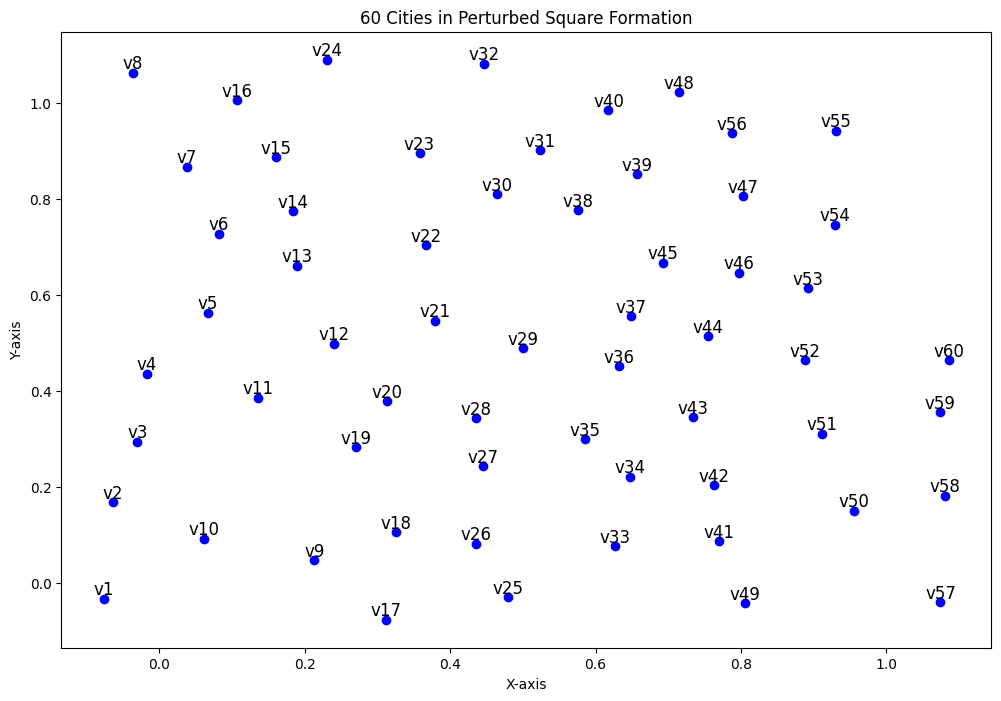

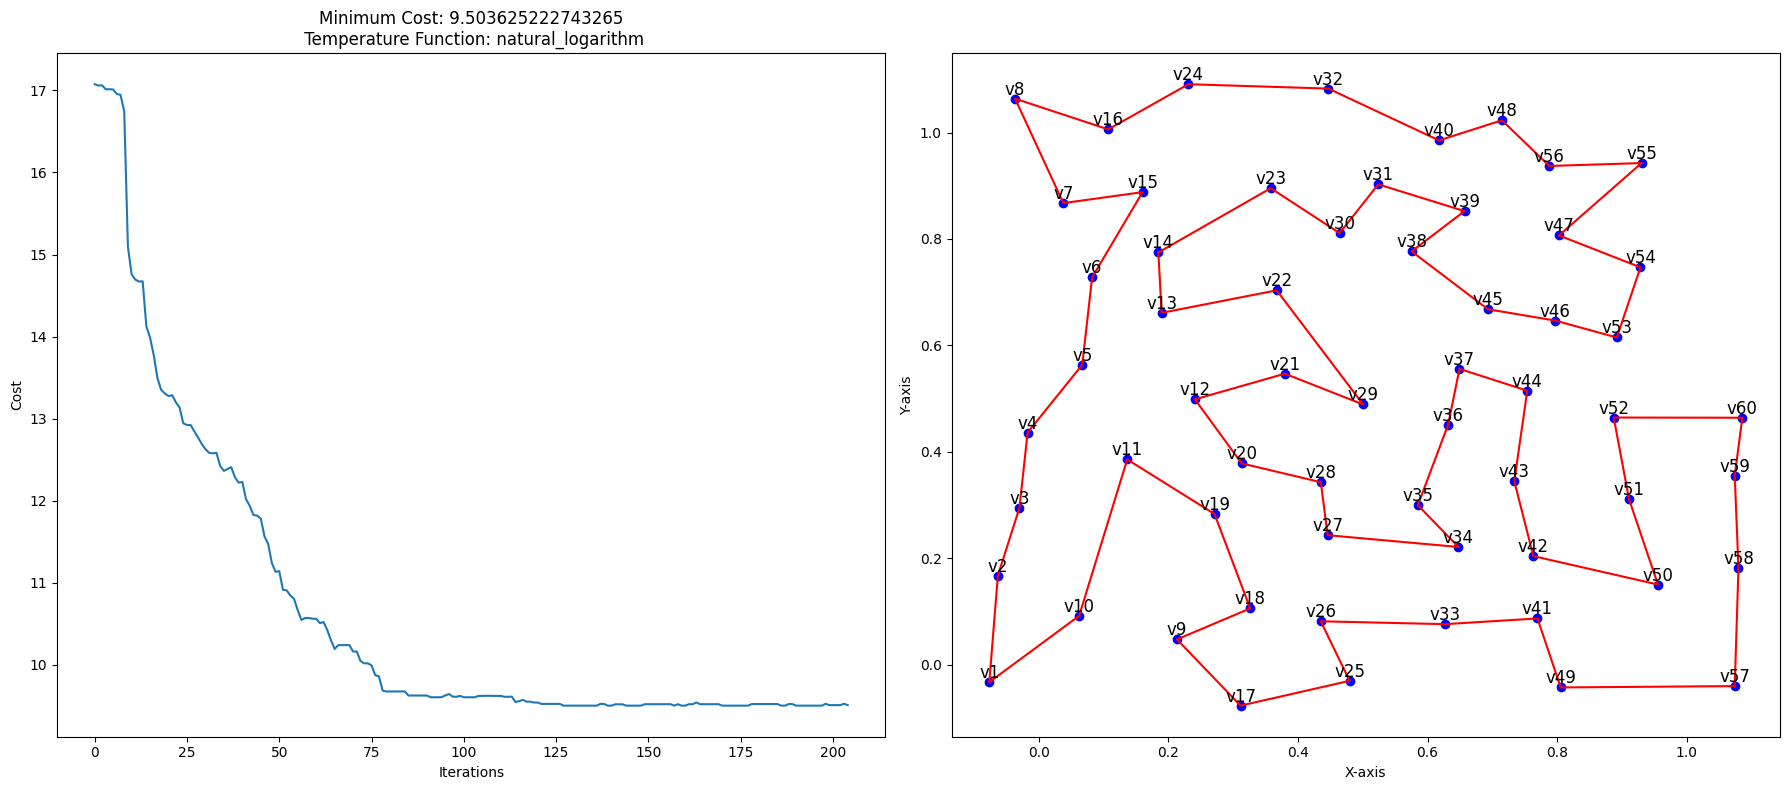

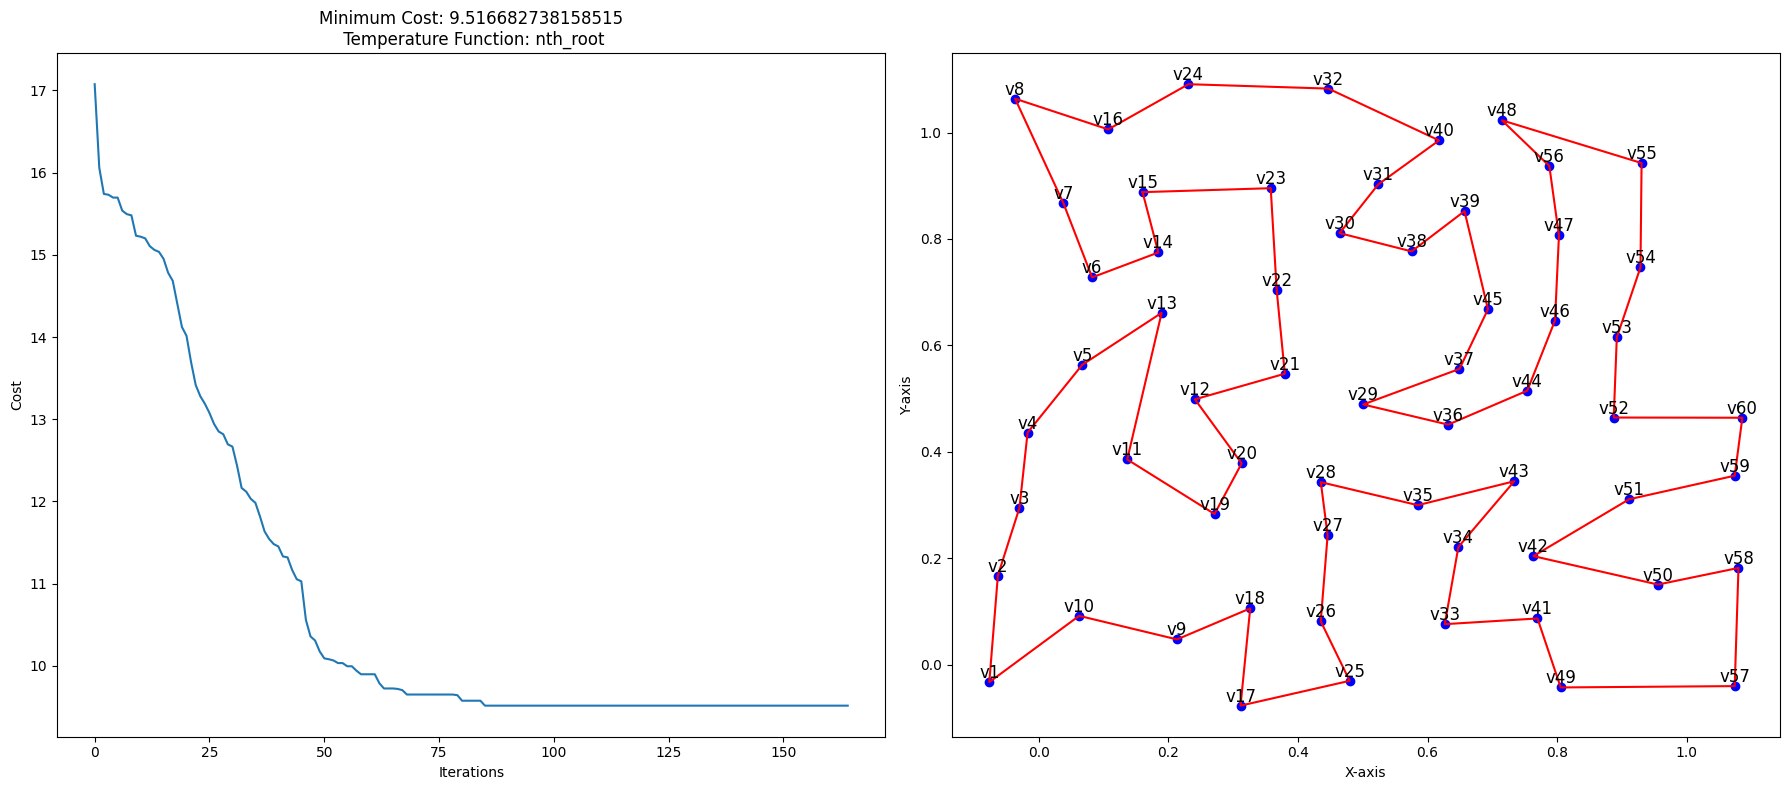

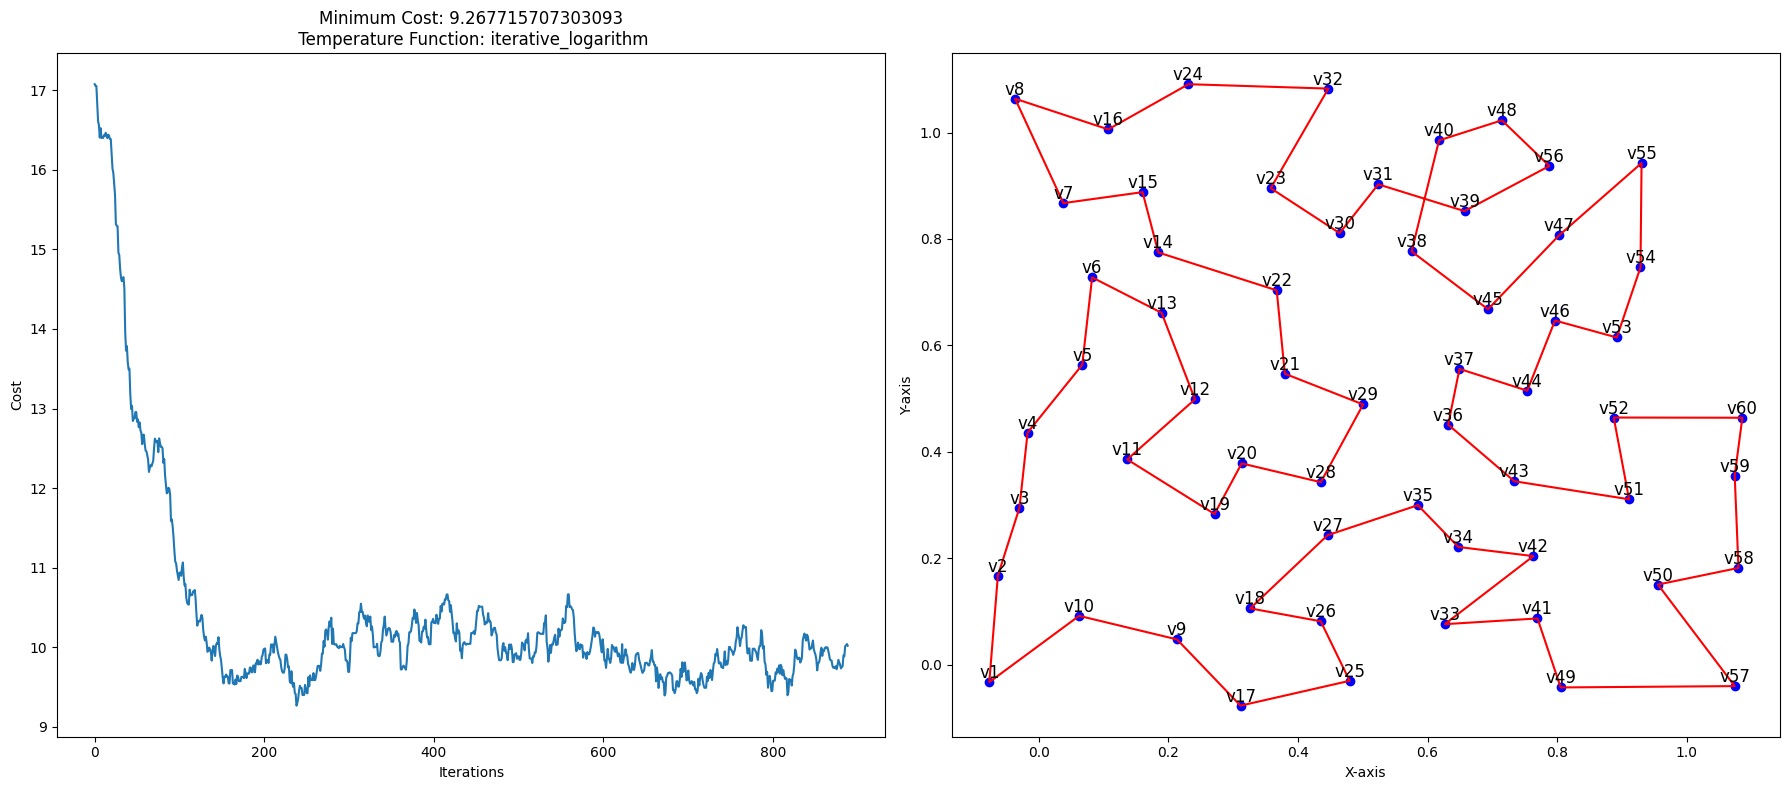

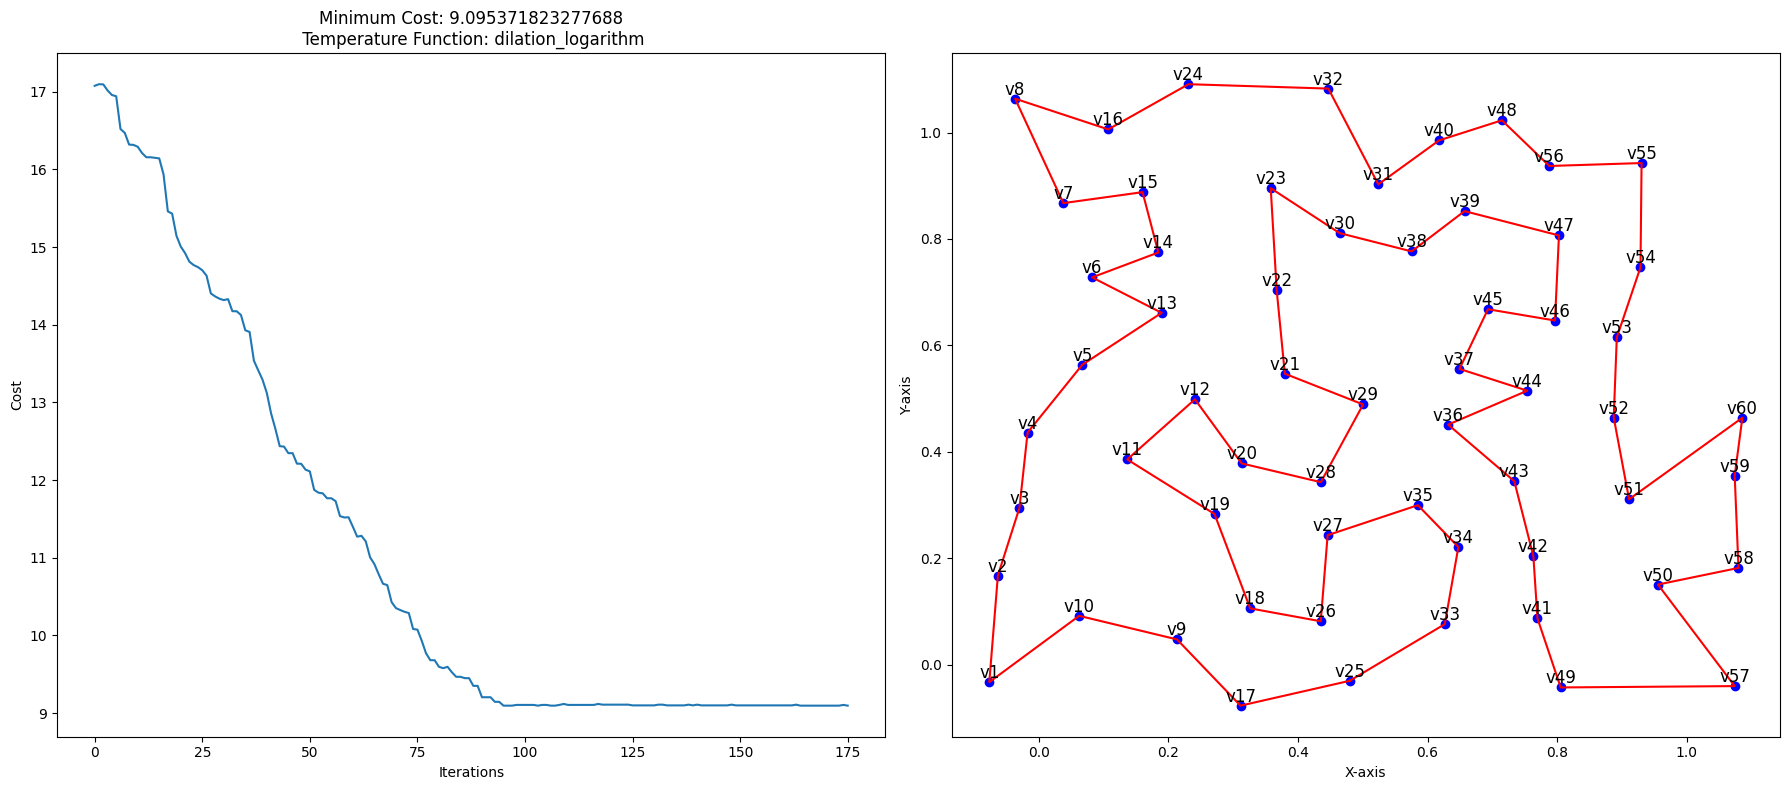

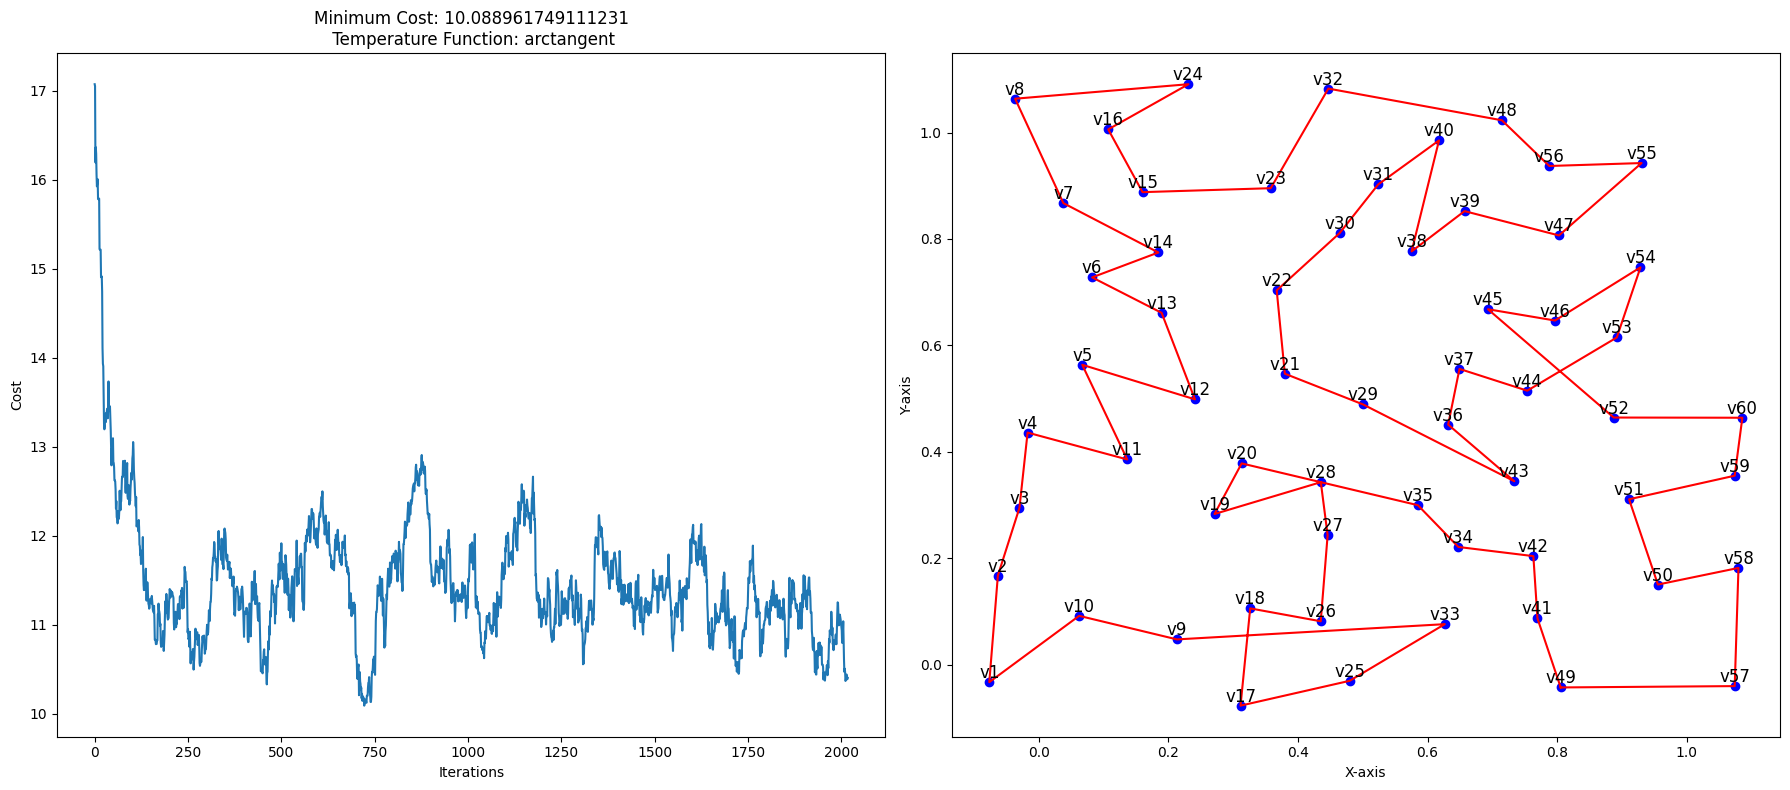

In [18]:
square_cities =  square_config(num_cities=60)
optimal_path(cities=square_cities, num_iterations=50000, num_cities=60, temp_function="natural_logarithm")
optimal_path(cities=square_cities, num_iterations=50000, num_cities=60, temp_function="nth_root")
optimal_path(cities=square_cities, num_iterations=50000, num_cities=60, temp_function="iterative_logarithm")
optimal_path(cities=square_cities, num_iterations=50000, num_cities=60, temp_function="dilation_logarithm")
optimal_path(cities=square_cities, num_iterations=50000, num_cities=60, temp_function="arctangent")

##**2 cercles configuration**

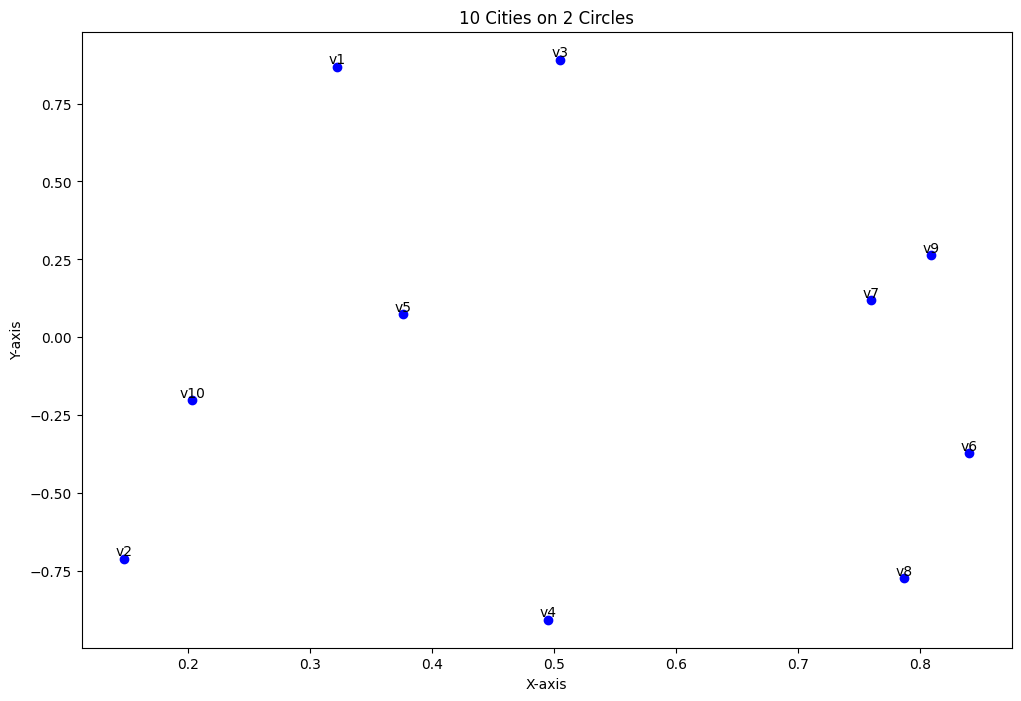

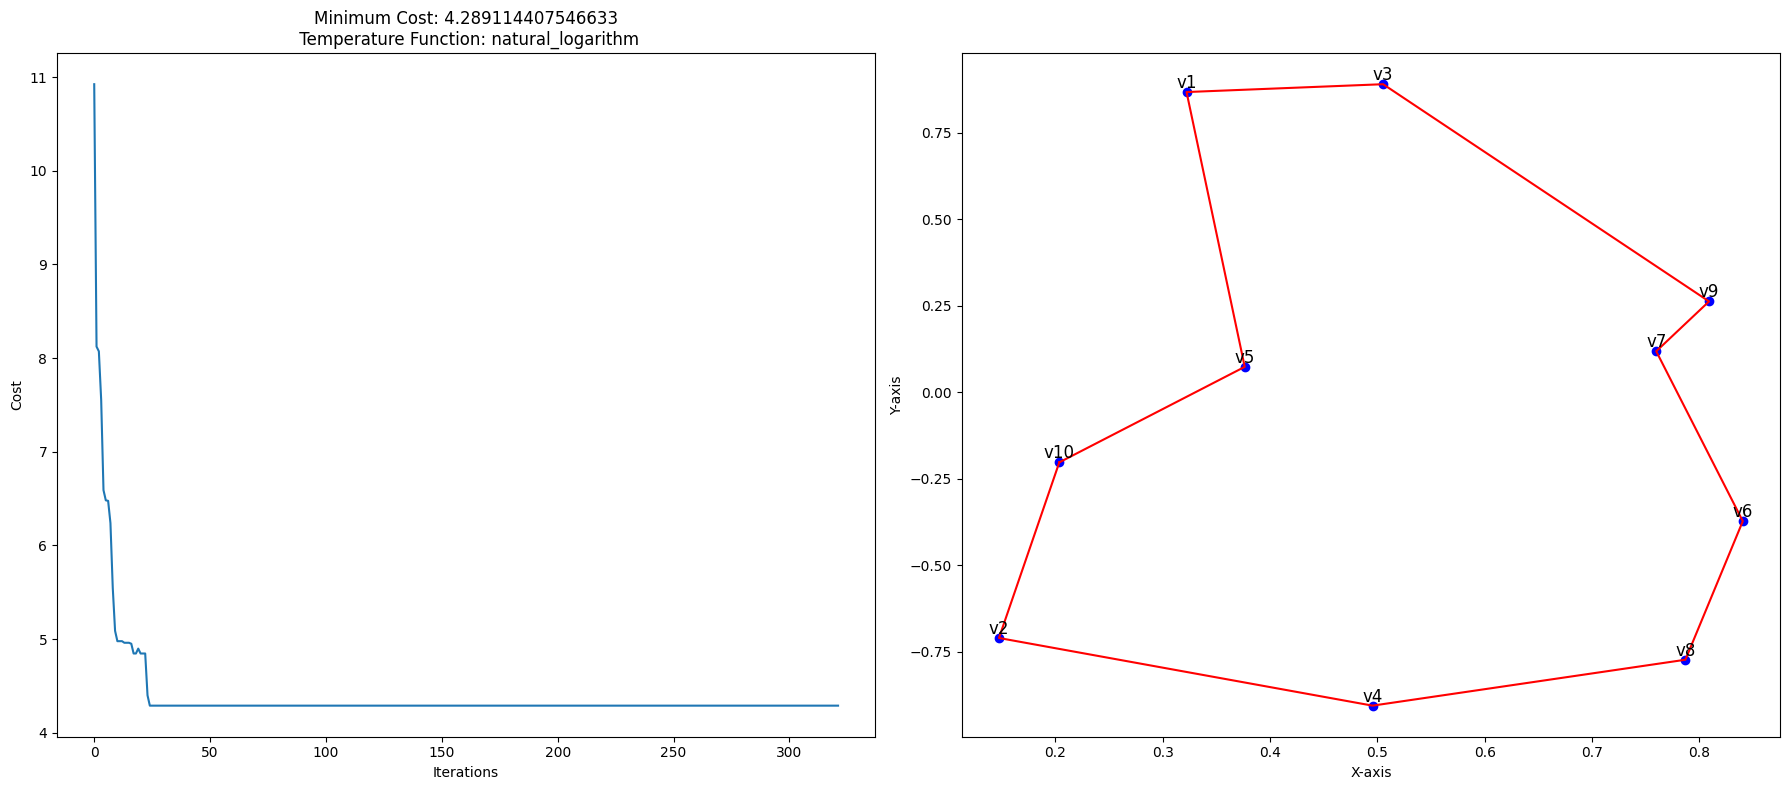

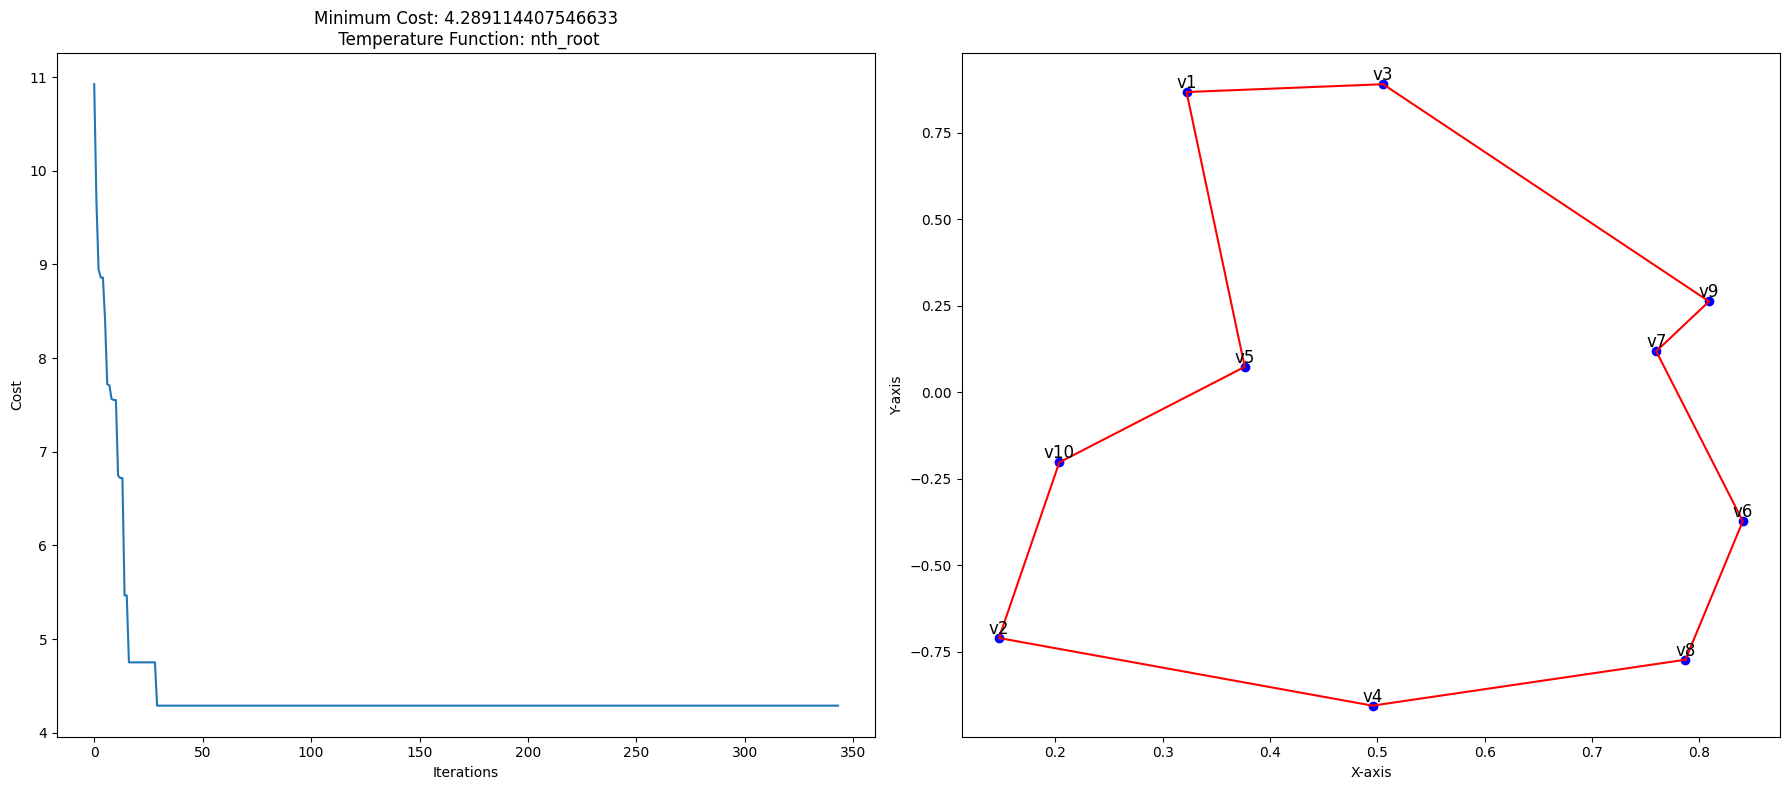

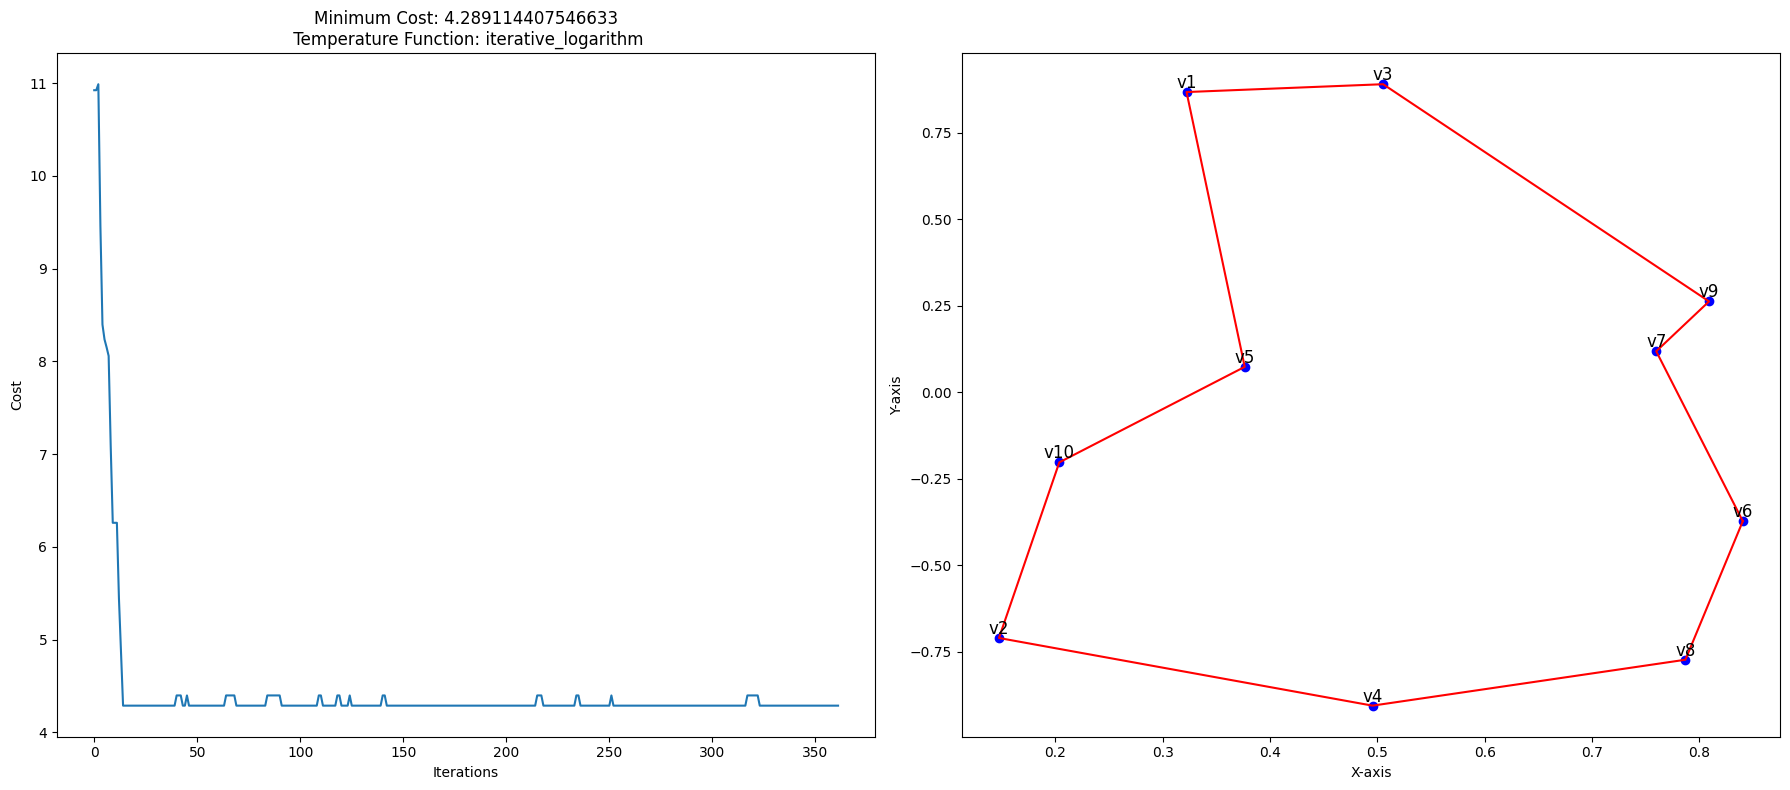

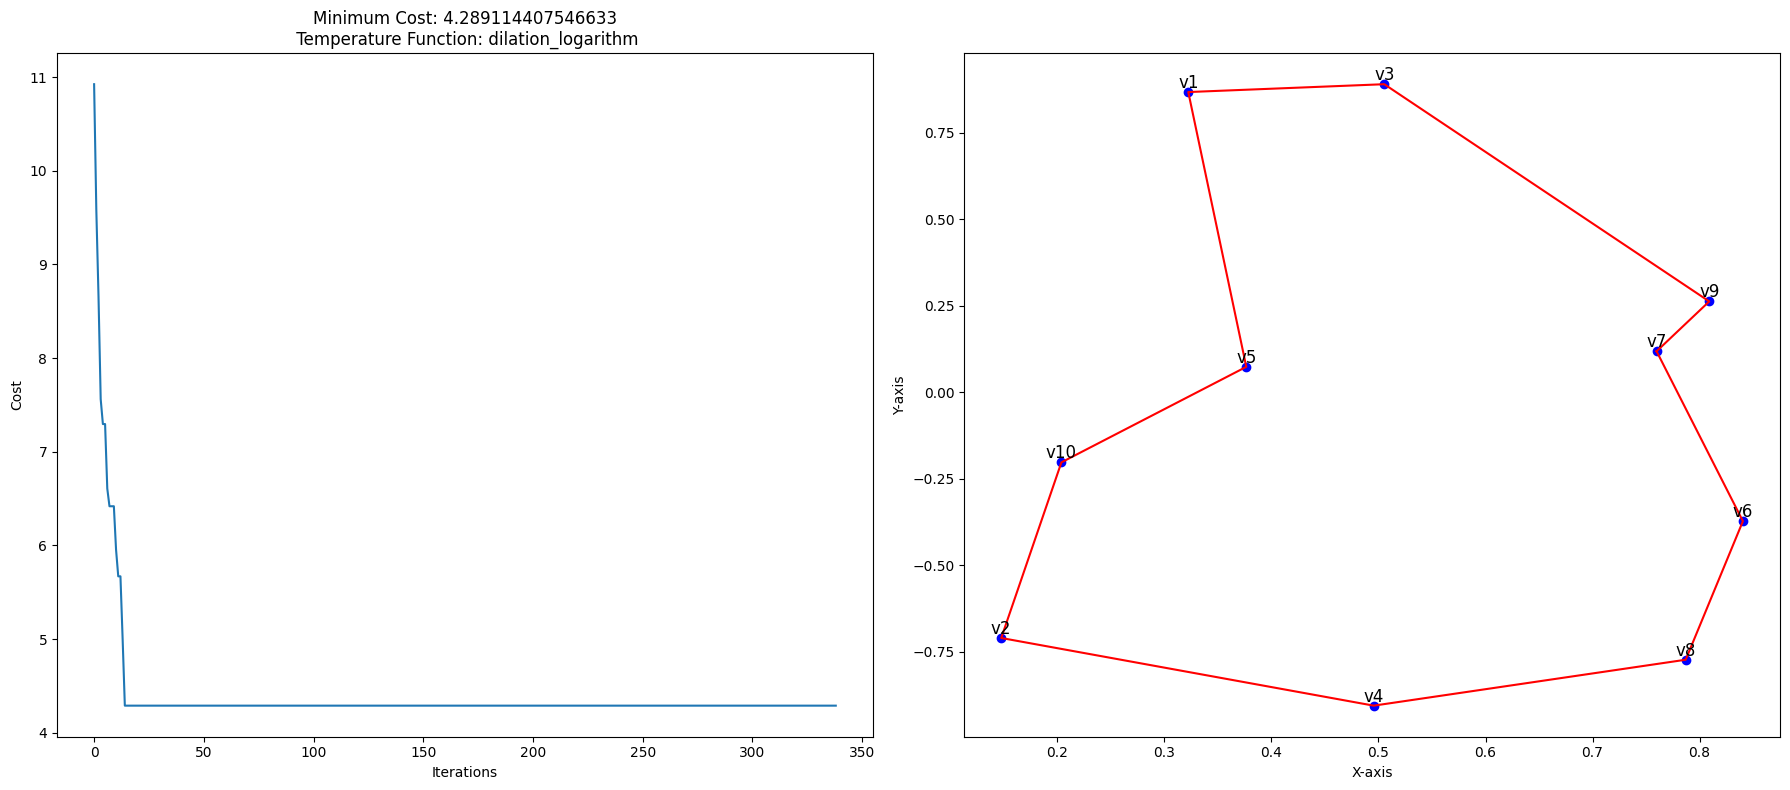

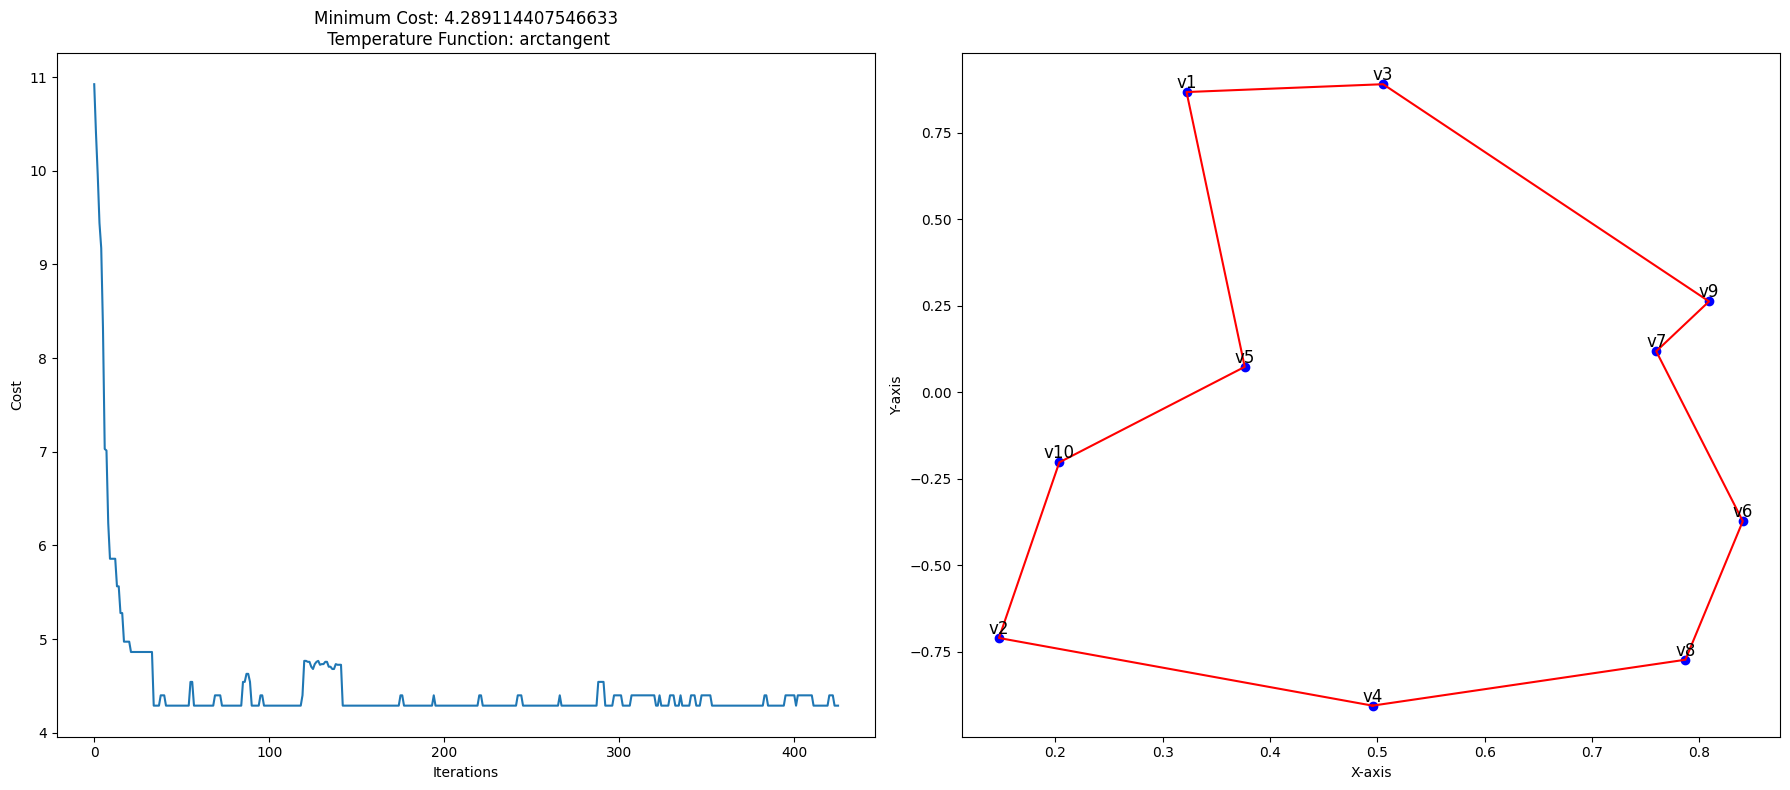

In [19]:
circle_cities = config_2_circles(num_cities=10)
optimal_path(cities=circle_cities, num_iterations=5000, num_cities=10, temp_function="natural_logarithm")
optimal_path(cities=circle_cities, num_iterations=5000, num_cities=10, temp_function="nth_root")
optimal_path(cities=circle_cities, num_iterations=5000, num_cities=10, temp_function="iterative_logarithm")
optimal_path(cities=circle_cities, num_iterations=5000, num_cities=10, temp_function="dilation_logarithm")
optimal_path(cities=circle_cities, num_iterations=5000, num_cities=10, temp_function="arctangent")

##**Gaussian configuration**

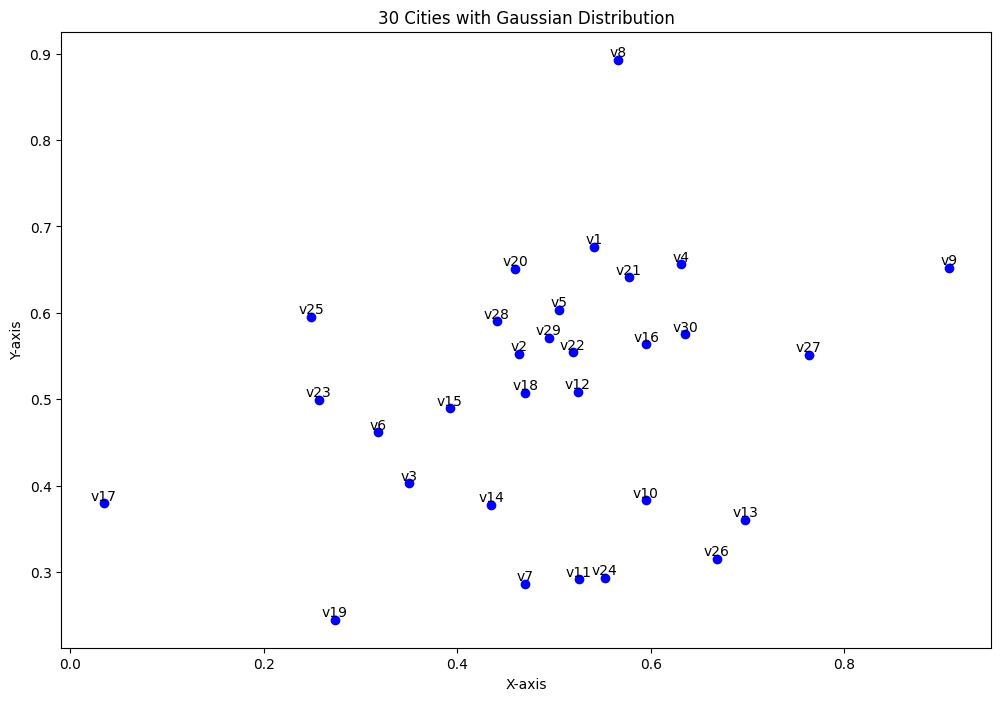

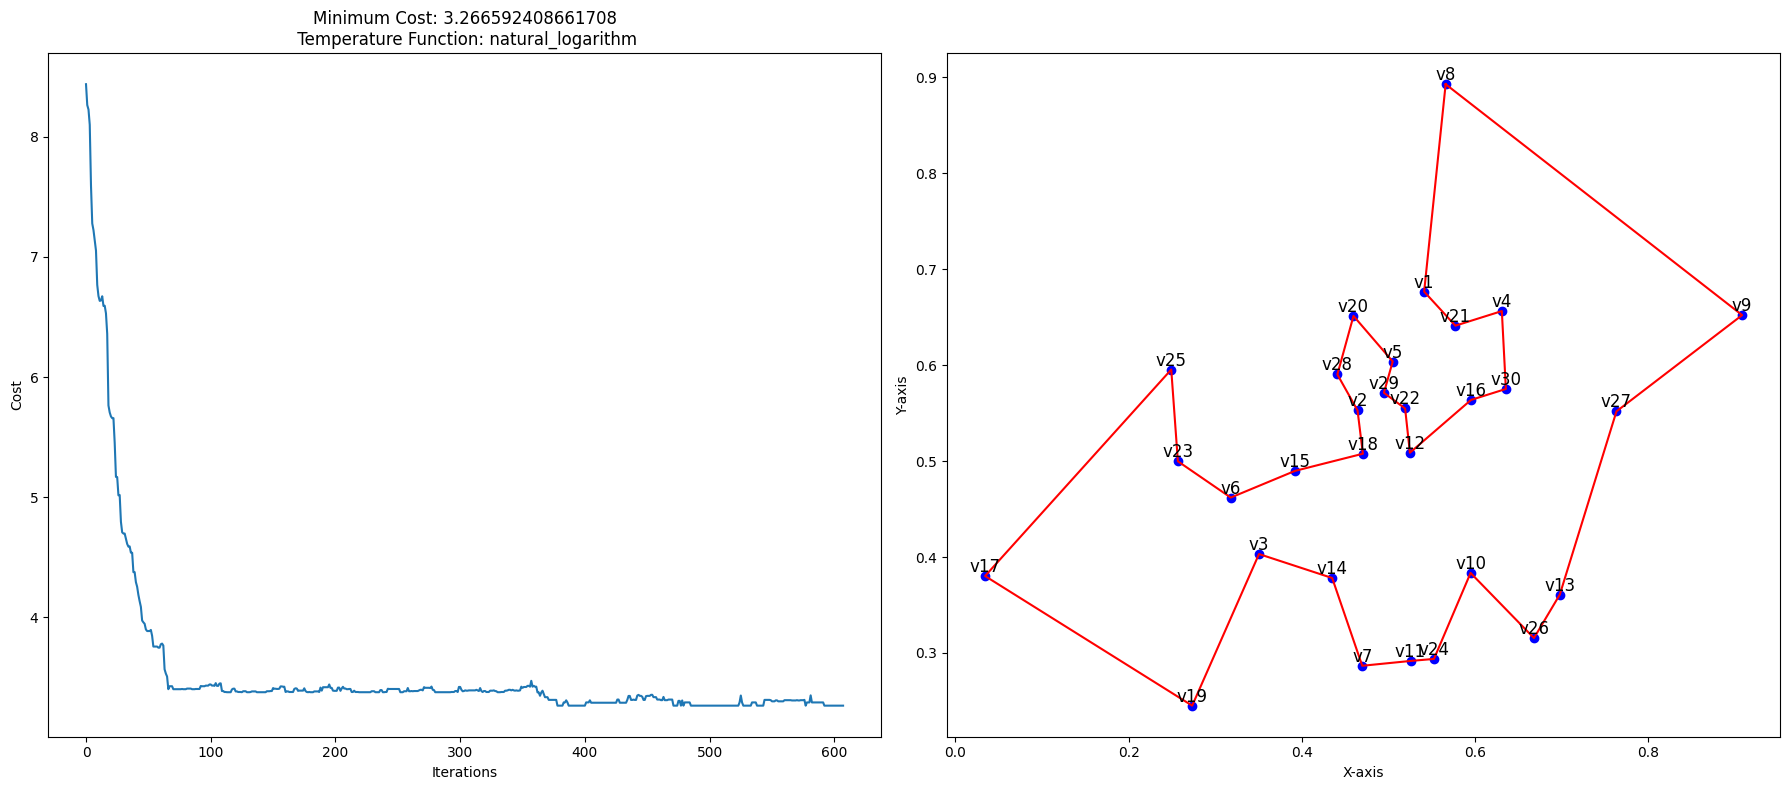

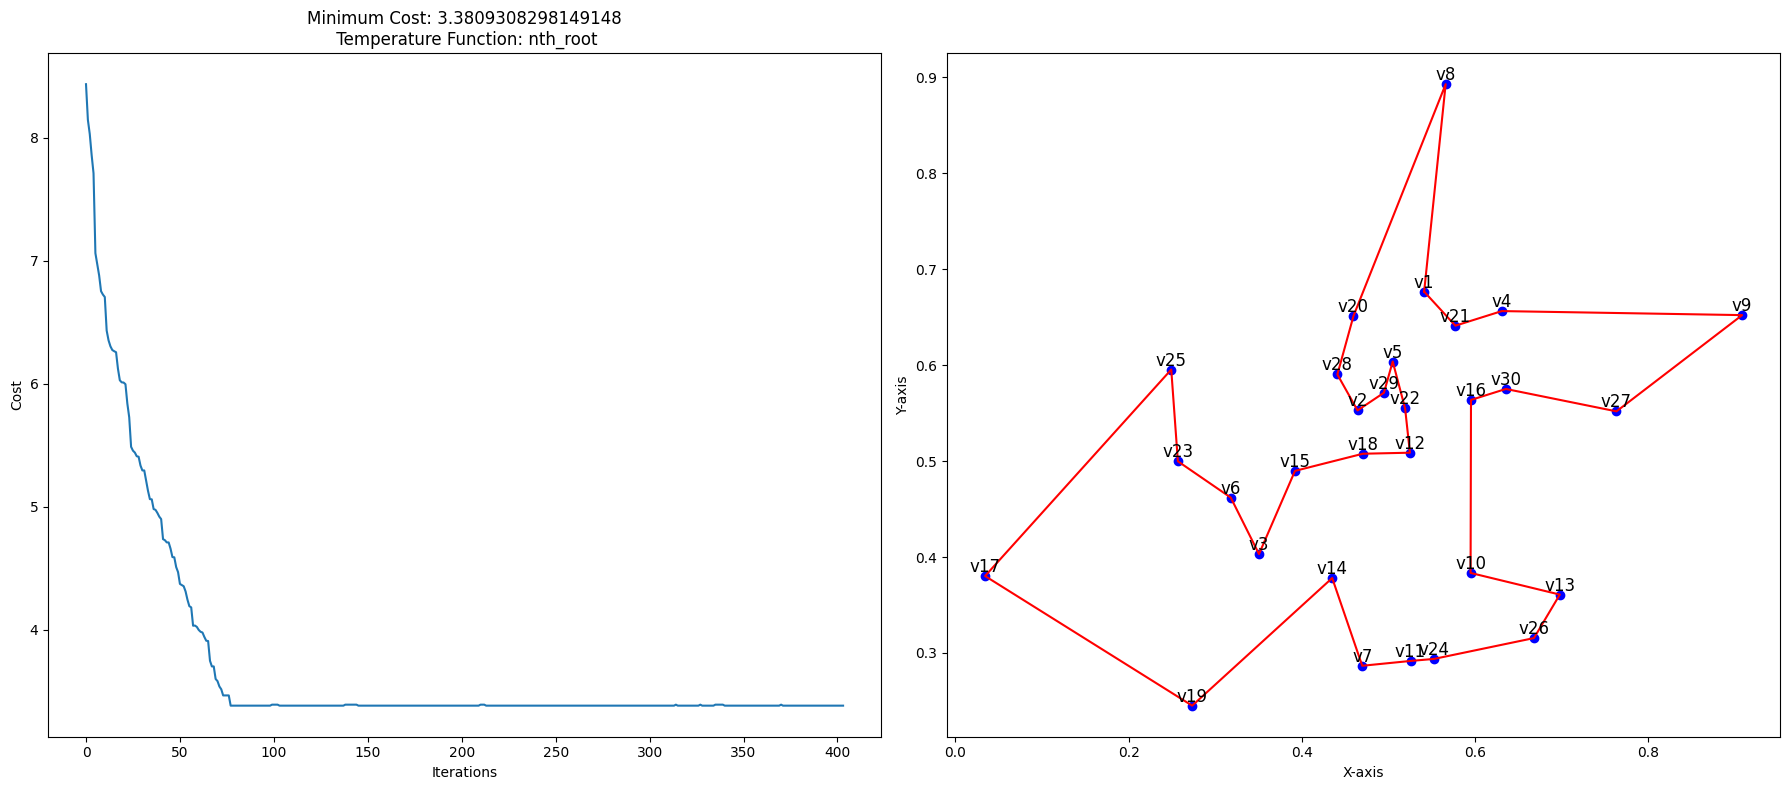

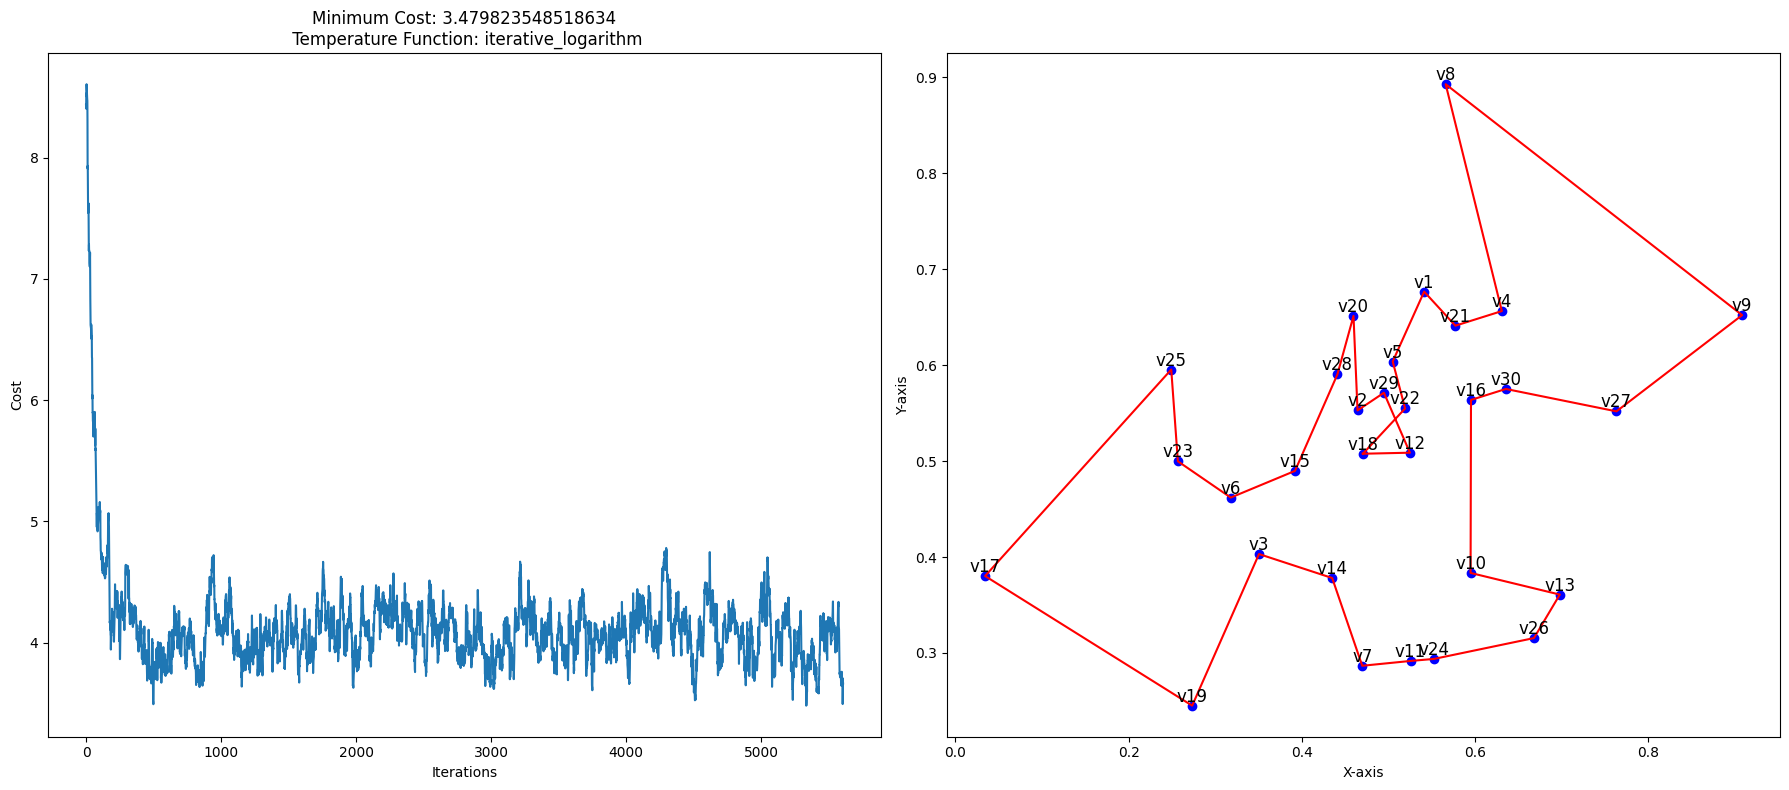

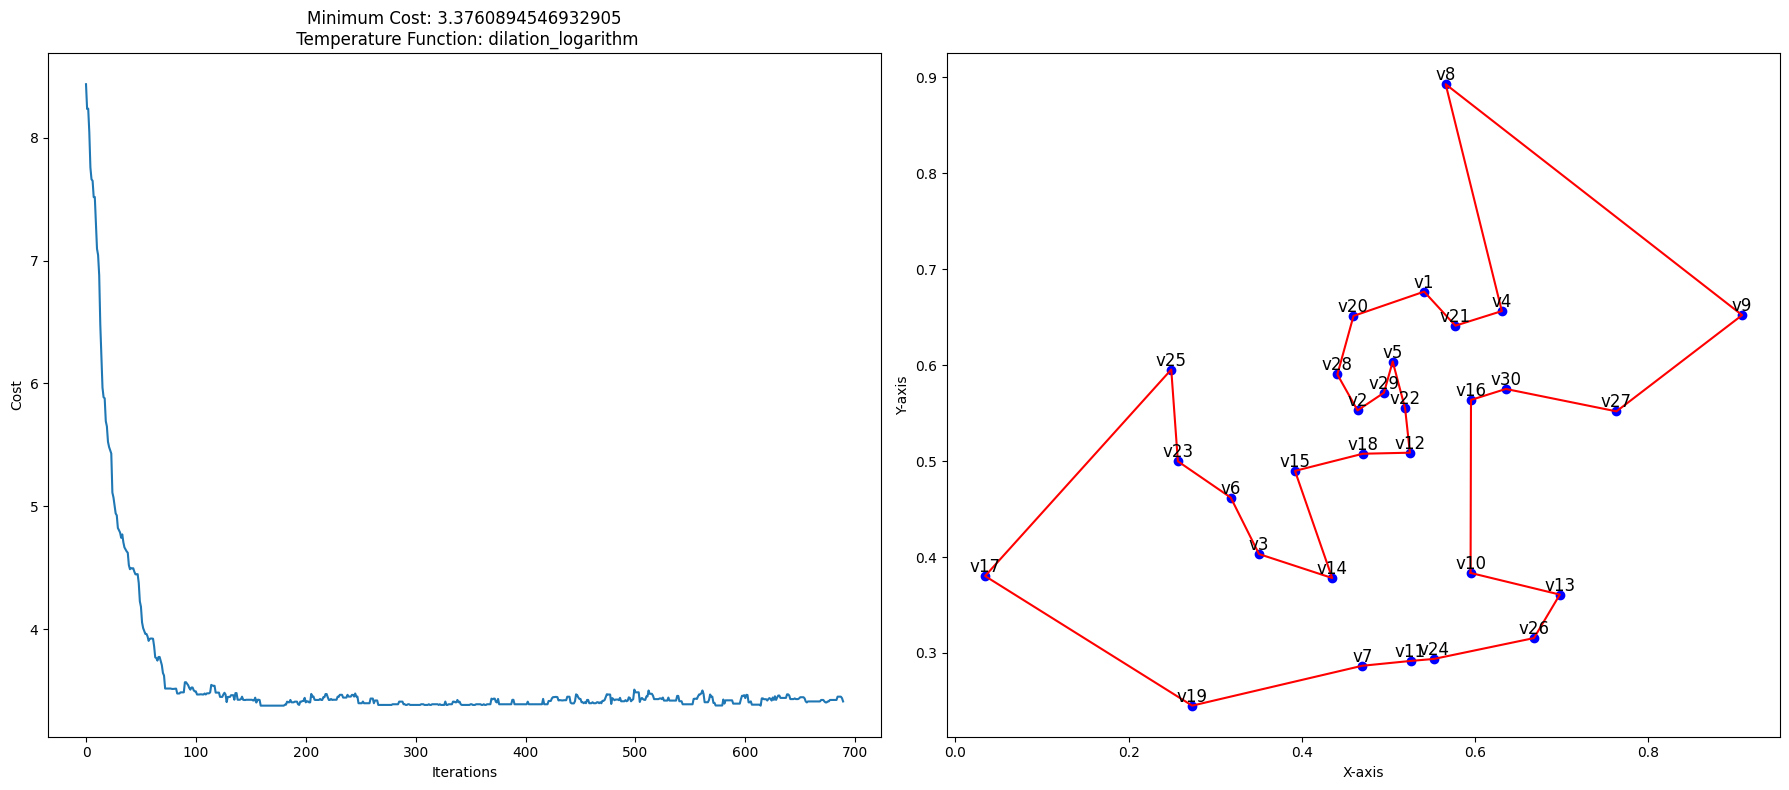

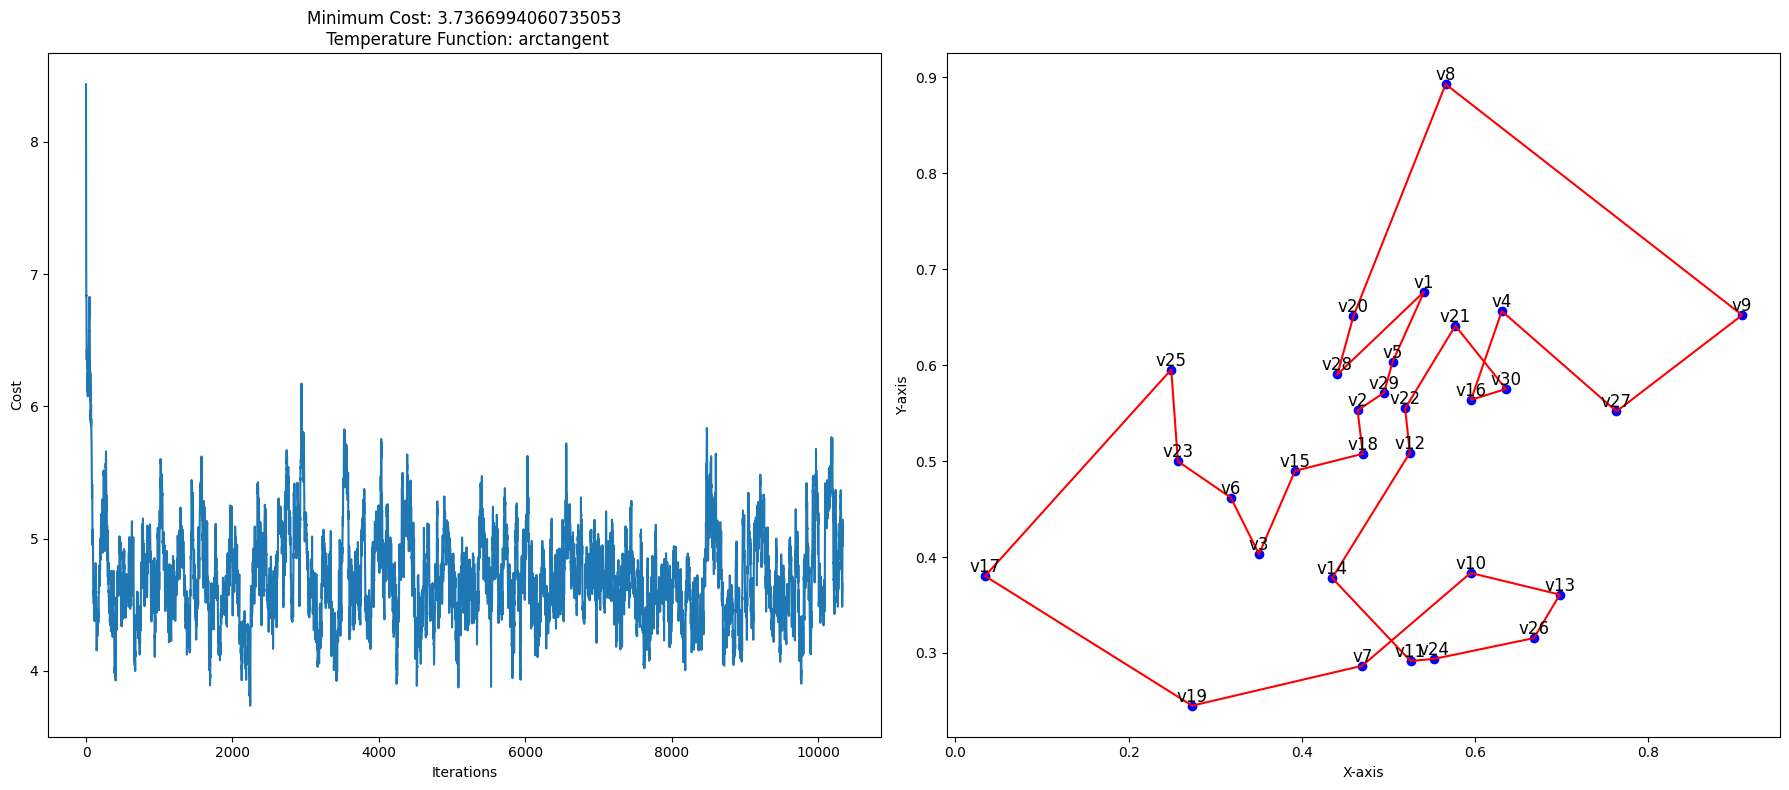

In [21]:
gaussian_cities = config_gaussian(30)
optimal_path(cities=gaussian_cities, num_iterations=50000, num_cities=30, temp_function="natural_logarithm")
optimal_path(cities=gaussian_cities, num_iterations=50000, num_cities=30, temp_function="nth_root")
optimal_path(cities=gaussian_cities, num_iterations=50000, num_cities=30, temp_function="iterative_logarithm")
optimal_path(cities=gaussian_cities, num_iterations=50000, num_cities=30, temp_function="dilation_logarithm")
optimal_path(cities=gaussian_cities, num_iterations=50000, num_cities=30, temp_function="arctangent")

## **Infinite configuration**

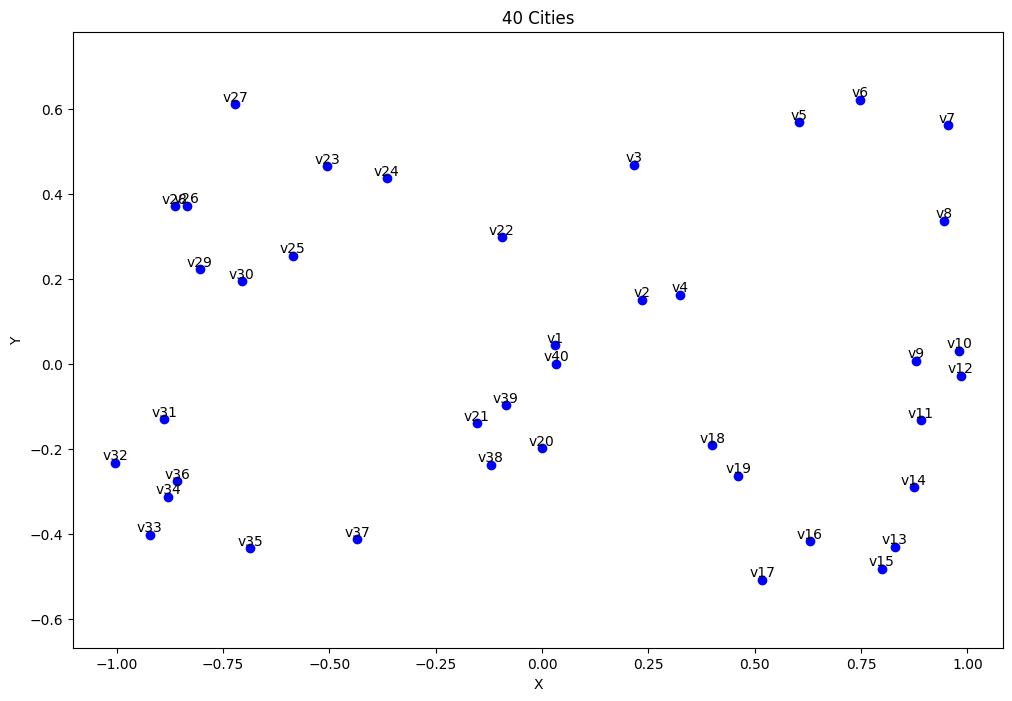

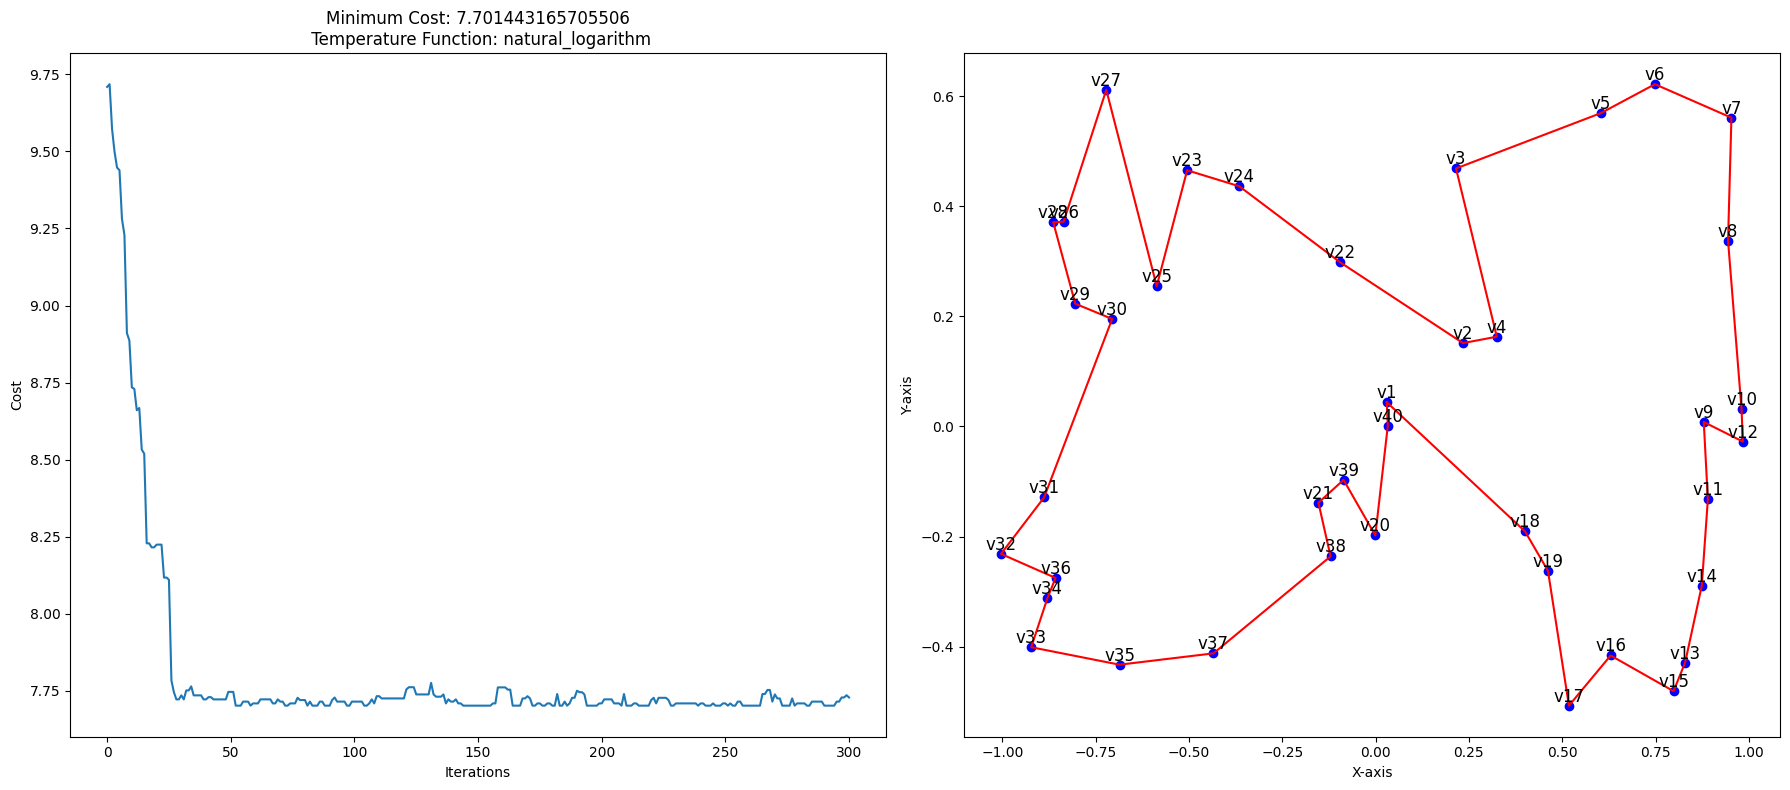

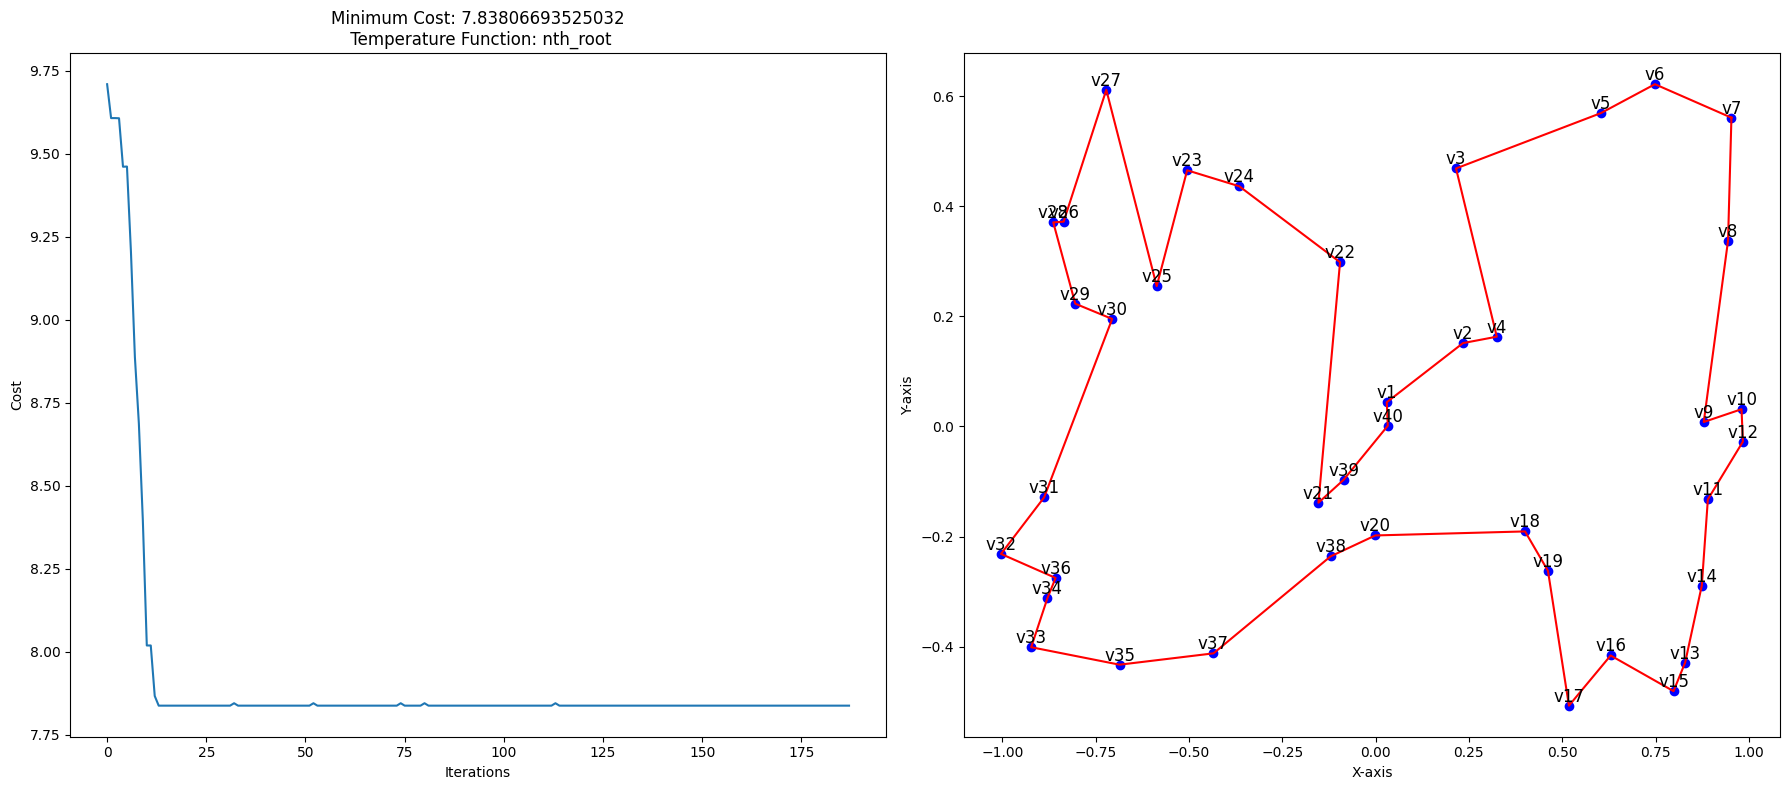

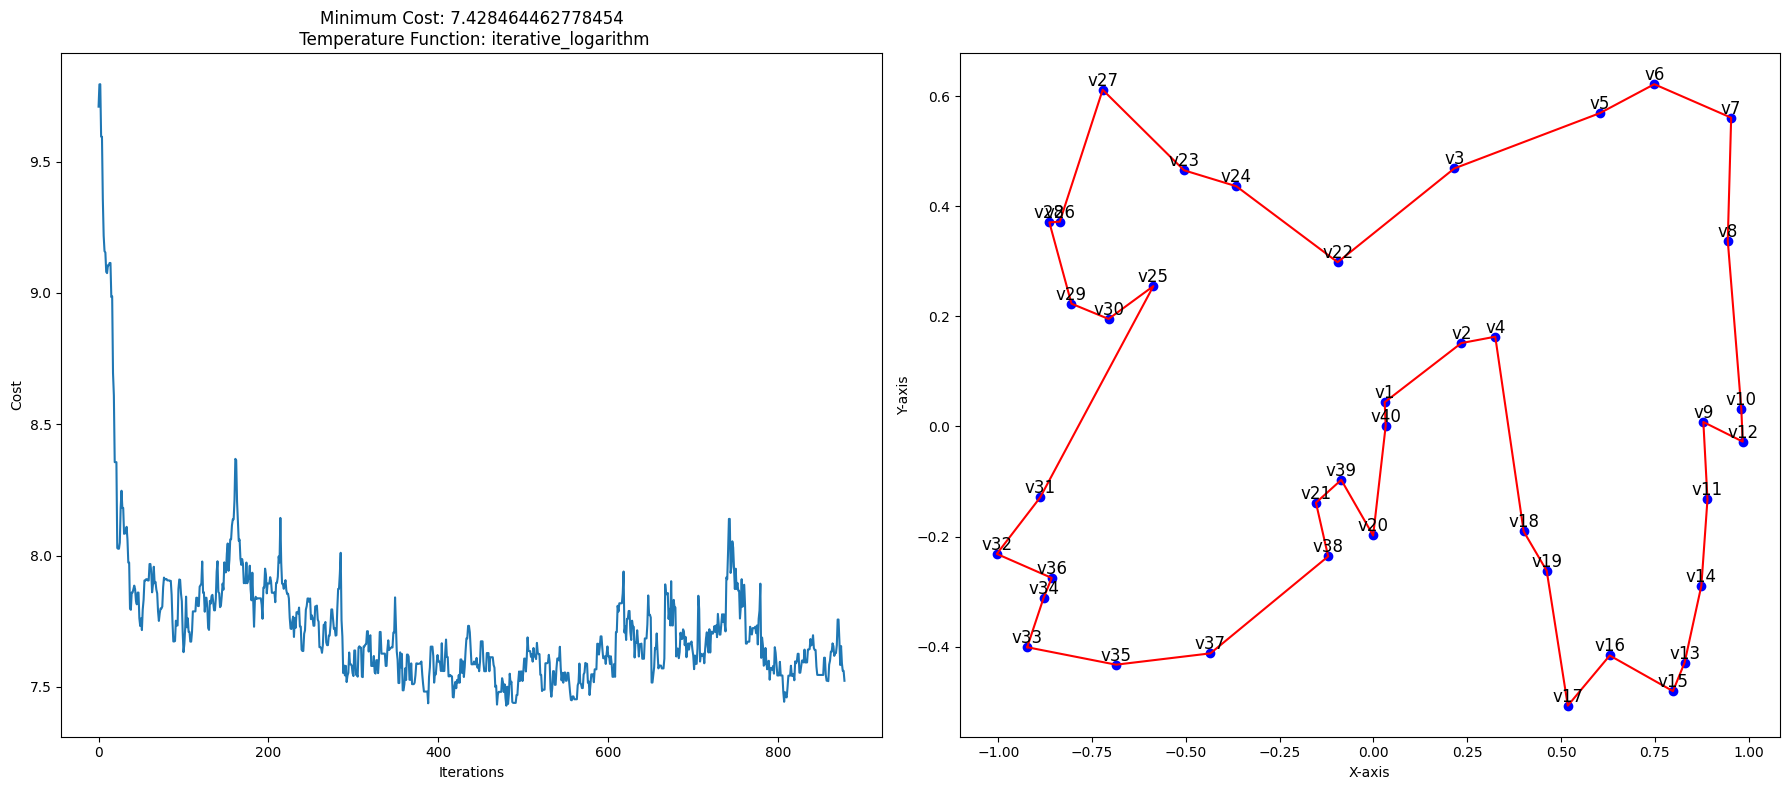

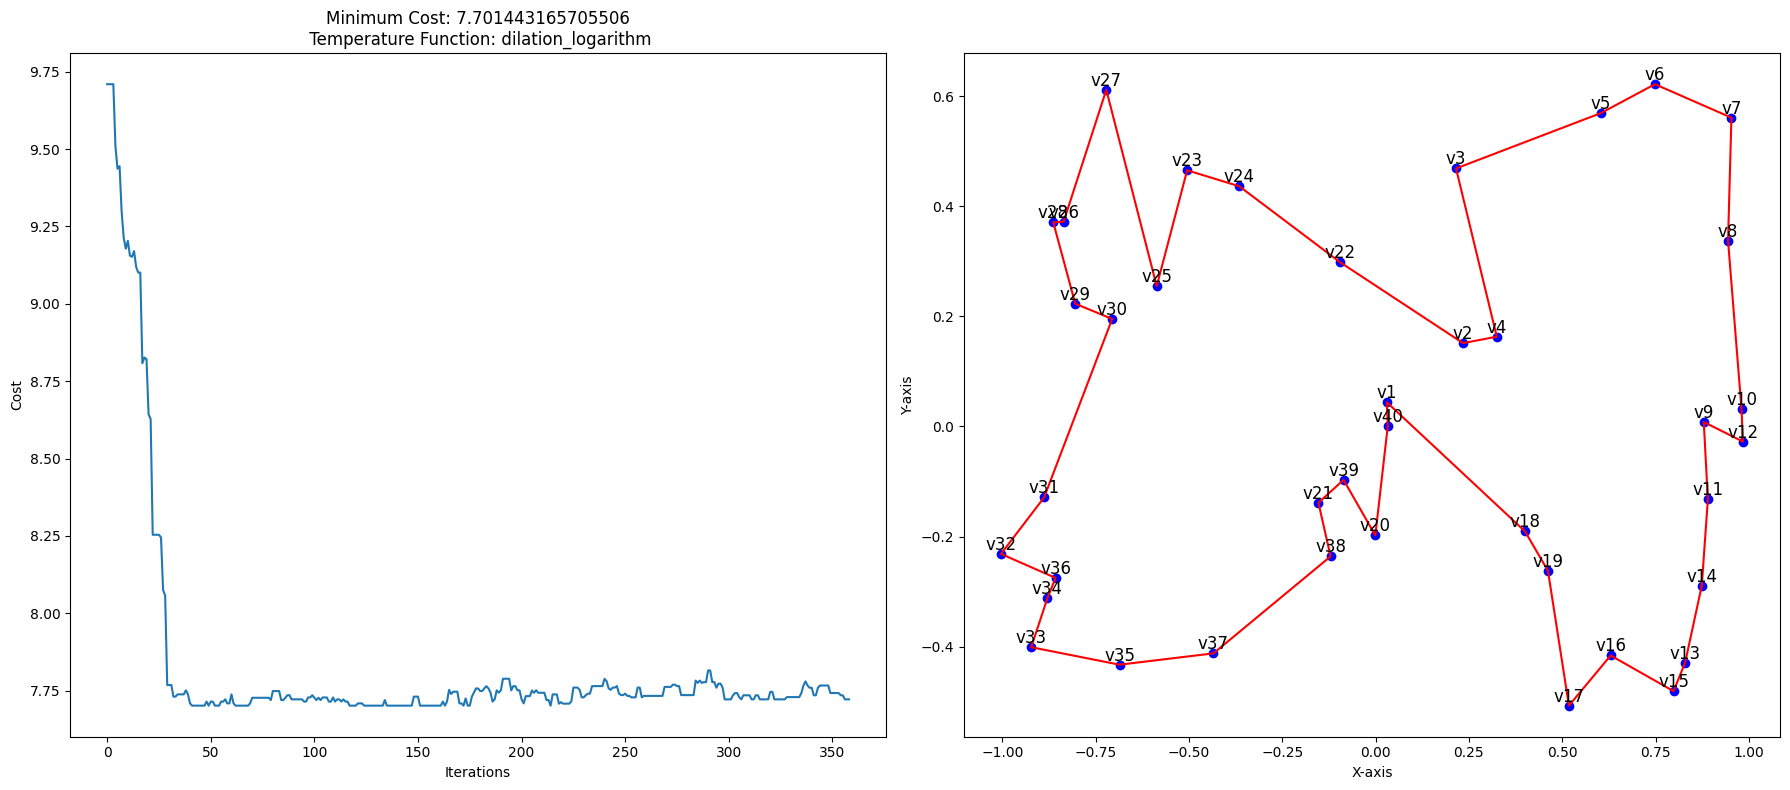

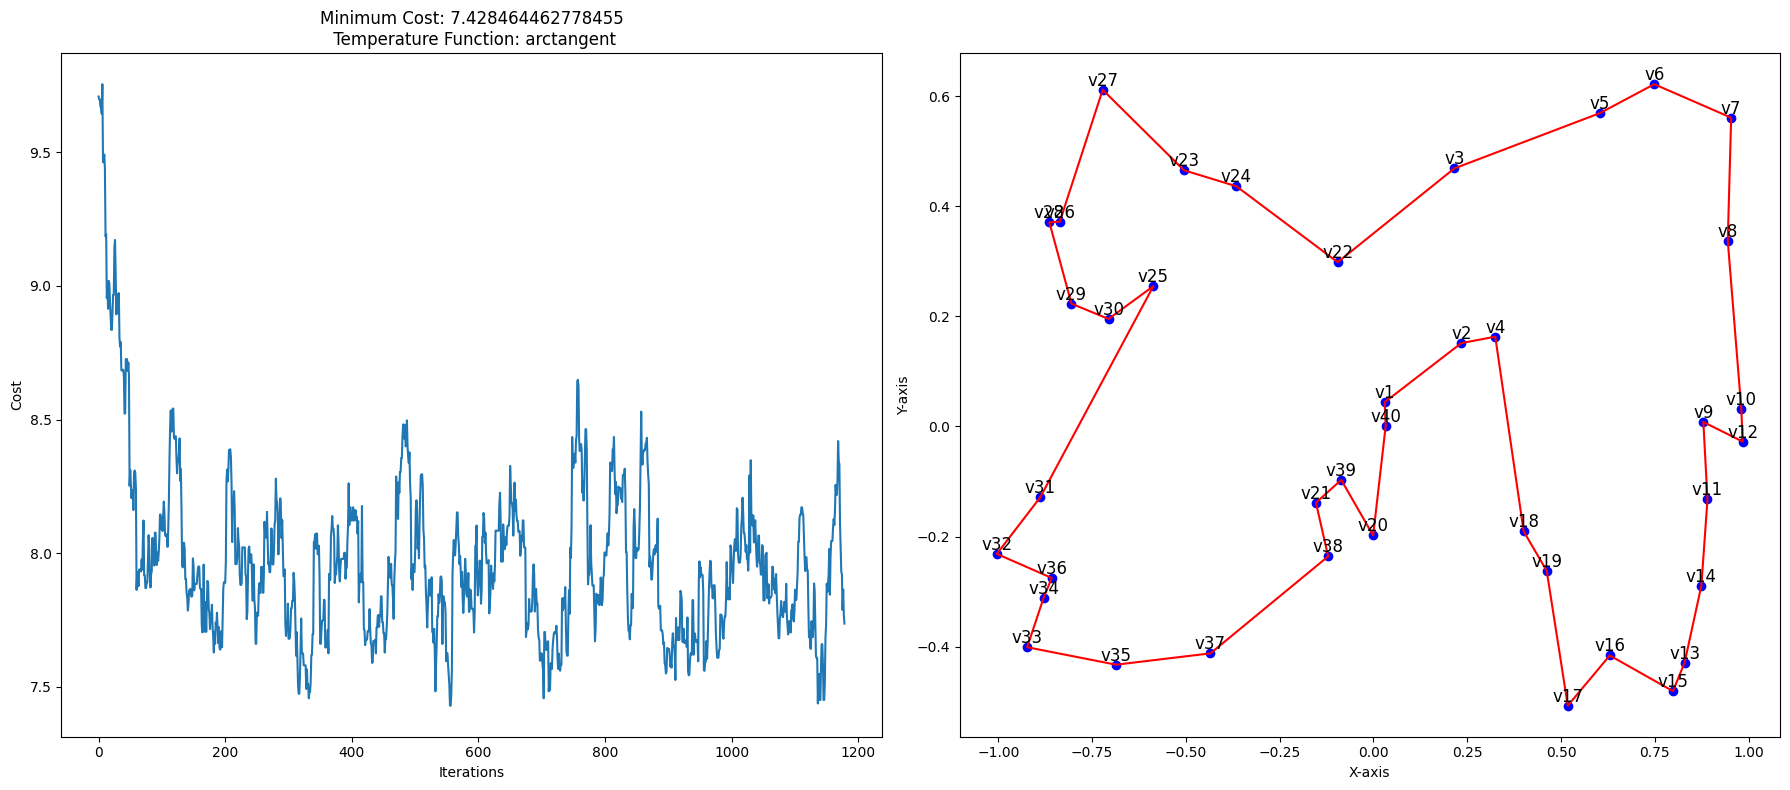

In [23]:
infinite_cities =  infinite_configuration(num_cities=40)
optimal_path(cities=infinite_cities, num_iterations=50000, num_cities=40, temp_function="natural_logarithm")
optimal_path(cities=infinite_cities, num_iterations=50000, num_cities=40, temp_function="nth_root")
optimal_path(cities=infinite_cities, num_iterations=50000, num_cities=40, temp_function="iterative_logarithm")
optimal_path(cities=infinite_cities, num_iterations=50000, num_cities=40, temp_function="dilation_logarithm")
optimal_path(cities=infinite_cities, num_iterations=50000, num_cities=40, temp_function="arctangent")

# **Theoretical and Practical Understanding**
* **Neighborhood by Inversion**: This approach of inverting elements between indices $i$ and $k$ is significant as it allows for a varied exploration of the configuration space while maintaining some proximity between successive configurations. This ensures that transitions between configurations are neither too abrupt nor too conservative, which is essential for an effective balance between exploration and exploitation.

* **Probabilistic Exploration**: Aligned with Markov chains, this method enables the algorithm to probabilistically move between configurations, balancing between searching for low-cost configurations and occasionally exploring less optimal solutions.

* **Temperature Function**: The use of functions such as natural logarithm, nth root, iterative logarithm, dilated logarithm, and arctangent has allowed for a diversified exploration of the impact of these functions on the algorithm's performance. Each function has uniquely influenced the probability of accepting less optimal solutions during the search, thereby affecting the convergence trajectory towards the optimal solution.